## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import matplotlib.image as mpimg
import os
from PIL import Image
from itertools import product

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from functools import partial

# Полностью отключить все предупреждения
warnings.filterwarnings("ignore")

os.makedirs("ims", exist_ok=True)
# os.makedirs("ims/current", exist_ok=True)
os.makedirs("ims/all", exist_ok=True)


volume = 160 # для Si в A^3

m0_cut_1 = 5999
m0_cut_2 = 3749
# 3749 (7.5 fms), 5999 (12 fms)

# In[116]:


plt.rcParams['font.family'] = 'serif'
import matplotlib
# matplotlib.use('Agg')
# print(matplotlib.get_backend())

## plot func

In [2]:
def plot_nonlinear_response_v4(folder, ax, j, version, alphas=[], taus=[]):


    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )

    data_probe = pd.read_csv(
        folder + '/probe_pulse_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )

    # Назначим читаемые имена колонкам
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']

    data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']


    t = data_both['time_fs']


    Jm_both_z  =  data_both['Jm_z']

    Jm_both_x  =  data_both['Jm_x']
    Jm_probe_x =  data_probe['Jm_x']

    Jm_both_y  =  data_both['Jm_y']
    Jm_probe_y =  data_probe['Jm_y']


    El_f_pump_z = data_both['E_ext_z']
    El_f_probe_x = data_both['E_ext_x']


    # 1:Time[fs] 2:Ac_ext_x[fs*V/Angstrom] 3:Ac_ext_y[fs*V/Angstrom] 4:Ac_ext_z[fs*V/Angstrom]
    #5:E_ext_x[V/Angstrom] 6:E_ext_y[V/Angstrom] 7:E_ext_z[V/Angstrom] 8:Ac_tot_x[fs*V/Angstrom]
    # 9:Ac_tot_y[fs*V/Angstrom] 10:Ac_tot_z[fs*V/Angstrom] 11:E_tot_x[V/Angstrom]
    # 12:E_tot_y[V/Angstrom] 13:E_tot_z[V/Angstrom]  14:Jm_x[1/fs*Angstrom^2] 15:Jm_y[1/fs*Angstrom^2] 16:Jm_z[1/fs*Angstrom^2]


    # Построим графики
    plt.figure(figsize=(10, 10))

    # Общий заголовок для всей фигуры
    plt.suptitle(' '.join(re.split('[/_]', folder)), fontsize=14, y=0.99)

    # Первый график: внешнее поле по z
    plt.subplot(4, 2, 1)
    plt.plot(t, El_f_pump_z, label='E_ext_z', color='#2CD311')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('Pump external electric field z')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    # Второй график: внешнее поле по x
    plt.subplot(4, 2, 2)
    plt.plot(t, El_f_probe_x, label='E_ext_z', color='c')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('Probe external electric field x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    # Четвертый график: суммарный ток по z
    plt.subplot(4, 2, 4)
    plt.plot(t, Jm_both_z, color='magenta')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
    plt.title('Full matter current density along z')
    plt.grid(True)

    plt.tight_layout()



    product_both_z = El_f_pump_z * Jm_both_z * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_both_z = np.cumsum(product_both_z * dt)

    product_both_x = El_f_probe_x * Jm_both_x * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_both_x = np.cumsum(product_both_x * dt)

    product_delta_x = El_f_probe_x * (Jm_both_x - Jm_probe_x) * volume
    # Разность по времени
    dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
    integral_delta_x = np.cumsum(product_delta_x * dt)



    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 3)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_both_z, label='ΔE = E_total - E_initial', color='r')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Energy transfer per unit cell along z')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()



    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 5)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_both_x, label='ΔE = E_total - E_initial', color='blue')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Energy transfer per unit cell along x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()


    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 6)
    # plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.plot(t, -integral_delta_x, label='ΔE = E_total - E_initial', color='black')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Δ energy transfer per unit cell along x')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()



    # Суммарный ток по x
    plt.subplot(4, 2, 7)
    plt.plot(t, Jm_both_x, color='#DC143C')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
    plt.title('Full matter current density along x')
    plt.grid(True)
    plt.tight_layout()




    delta_Jm_x = Jm_both_x - Jm_probe_x


    if version=='v1':

        t_array_cut = np.array(t[m0_cut_1:])[::50]
        j_exp = np.array(delta_Jm_x[m0_cut_1:])[::50]
        # (dummy_t, j0, j_final, tau)
        p0 = [0.03, 0.01, 6.65]   # начальные приближения (n, tau)
        popt, pcov = curve_fit(drude_current_v1, t_array_cut, j_exp, p0=p0)
        j0, j_final, tau= popt
        j_fit = drude_current_v1(0, j0, j_final, tau)
    
        ratio = j_final/max(delta_Jm_x)
    
        # Разностный ток по x
        plt.subplot(4, 2, 8)
        plt.plot(t, (Jm_both_x - Jm_probe_x), color='#00FF7F')
        plt.plot(t_array_cut, j_fit, '--', label=rf"$\tau = {tau:.2f}\ \mathrm{{fs}},  j_{{\rm final}} : j_{{\rm max}} = {ratio:.2f}$", color='r')
        plt.xlabel('Time [fs]')
        plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
        plt.title('Δ matter current density along x')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
    
    
        plt.savefig("ims/all/" + str(j)+ '_' + folder + ".png", dpi=200)
    
    
        dt = np.diff(t, prepend=t[0])
    
        arr = np.array(np.cumsum(-2.64*El_f_probe_x[3000:7000]*dt[3000:7000]))
        a_fin = arr[-1]



    ## для gen drude подавать в качестве начального j_final найденный ранее
    
    return a_fin, tau, j_final

## extract funcs

In [3]:
def extract_c_num(s):
    start = s.index('c') + 1
    end = s.index('_', start)
    return int(s[start:end])

def extract_s_num(s):
    start = s.index('_s') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_k_num(s):
    start = s.index('_k') + 2
    end = s.index('_', start)
    return int(s[start:end])

def extract_a_num(s):
    start = s.index('_a') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_r_num(s):
    start = s.index('_r') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_i_num(s):
    start = s.index('_i') + 2
    end = s.index('_', start)
    return float(s[start:end])

def extract_p(s):
    match = re.search(r'p([^_]+)', s)
    s1 = match.group(1).split('d')[0]
    s2 = match.group(1).split('d')[1]
    return float(s2+s1)
        # return match.group(1)[-2:]+match.group(1)[:-2]

In [4]:
## drude func

In [5]:
def drude_current_v1(dummy_t, j0, j_final, tau):

    # tau = 6.65
    step_dt = 0.002

    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )


    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']

    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']

    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_1:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_1:]) 


    # --- Решение через явный шаг Эйлера ---

    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0

    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-j_final)/tau)


    return j_euler[::50]


In [6]:
def tau_from_alpha(alpha, alphas, taus):
    return np.interp(alpha, alphas, taus)

## Plots

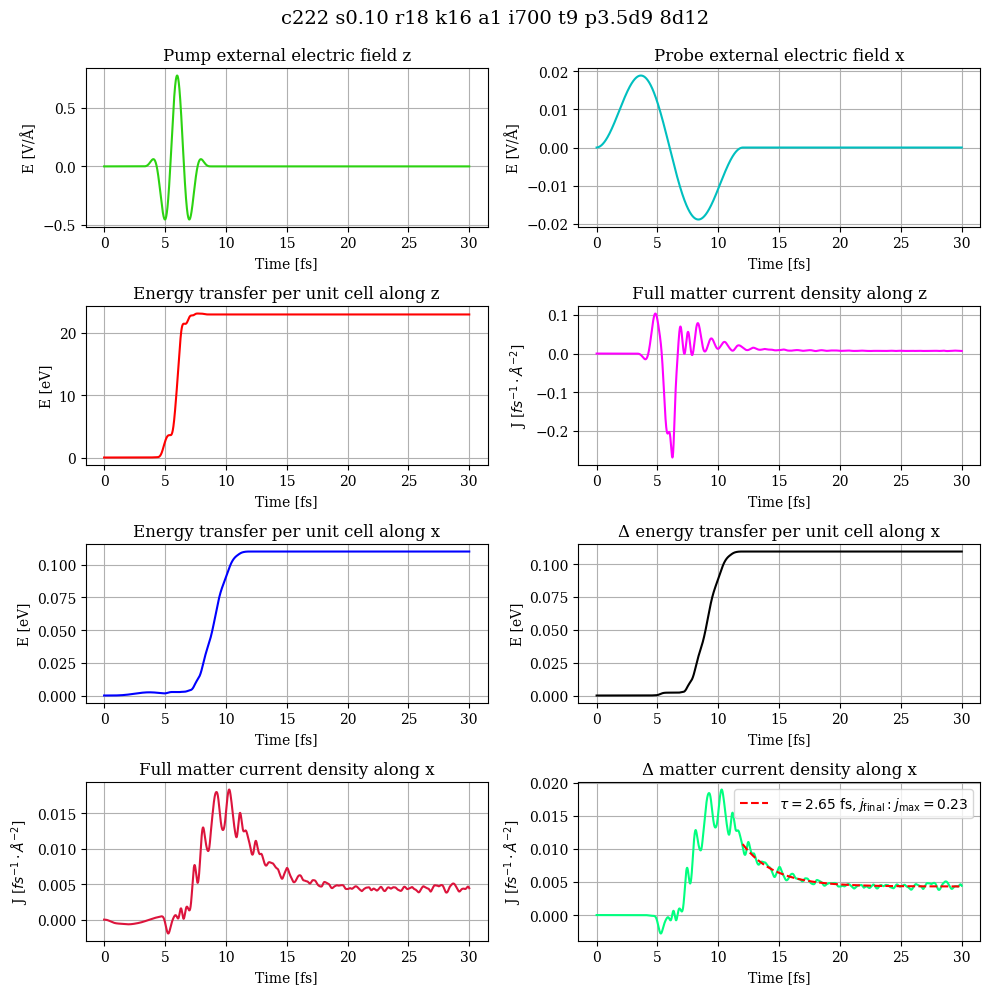

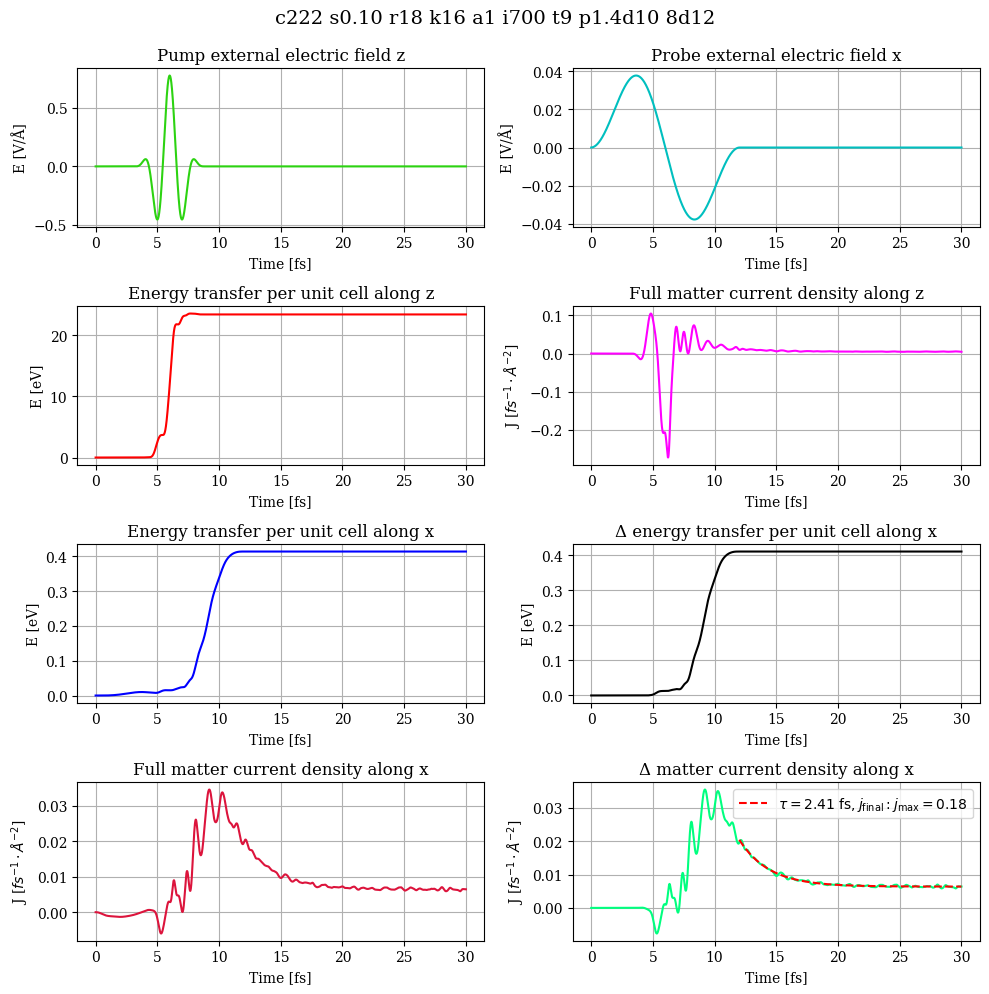

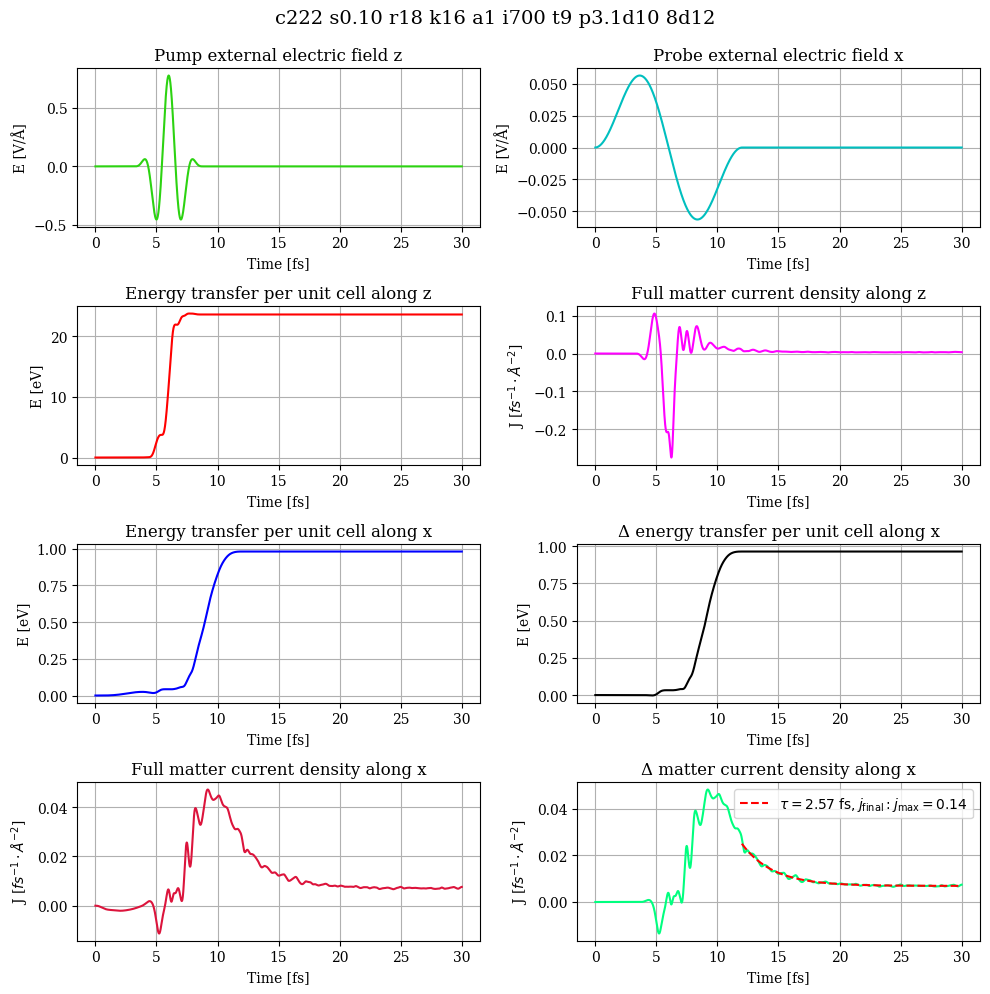

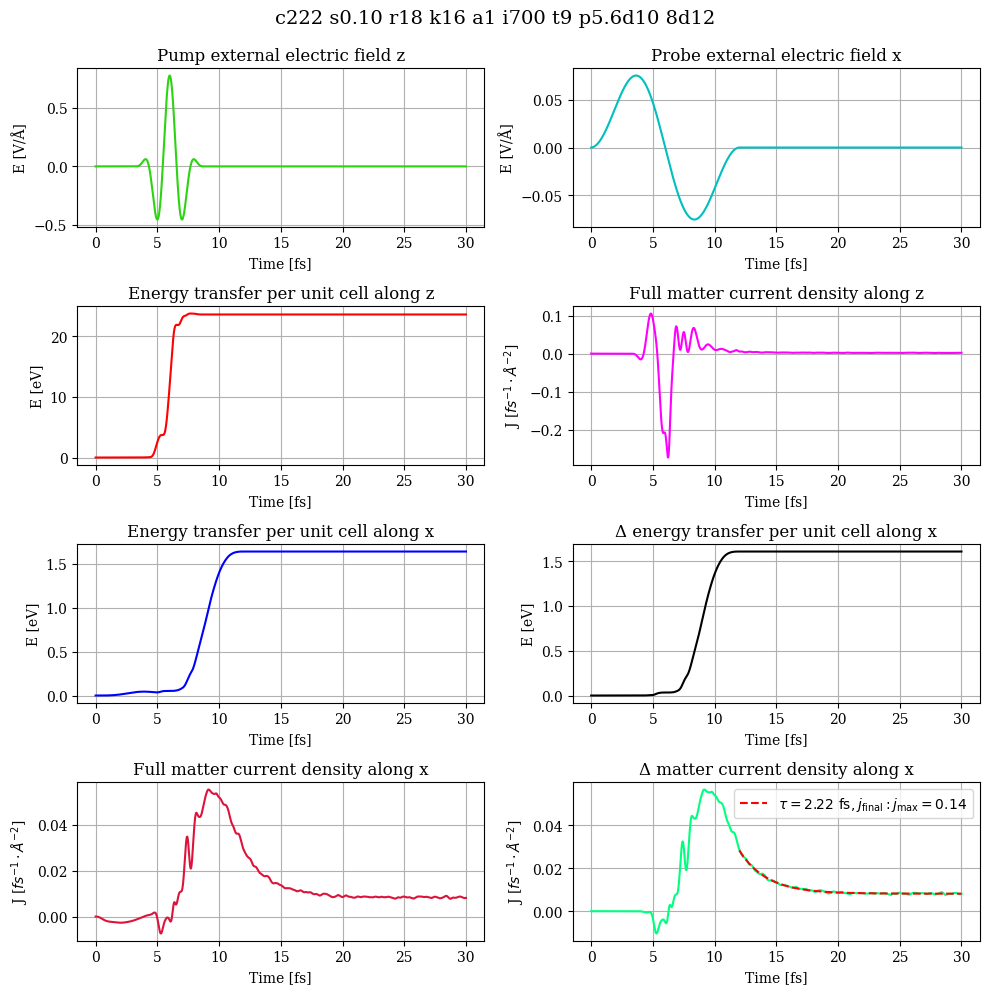

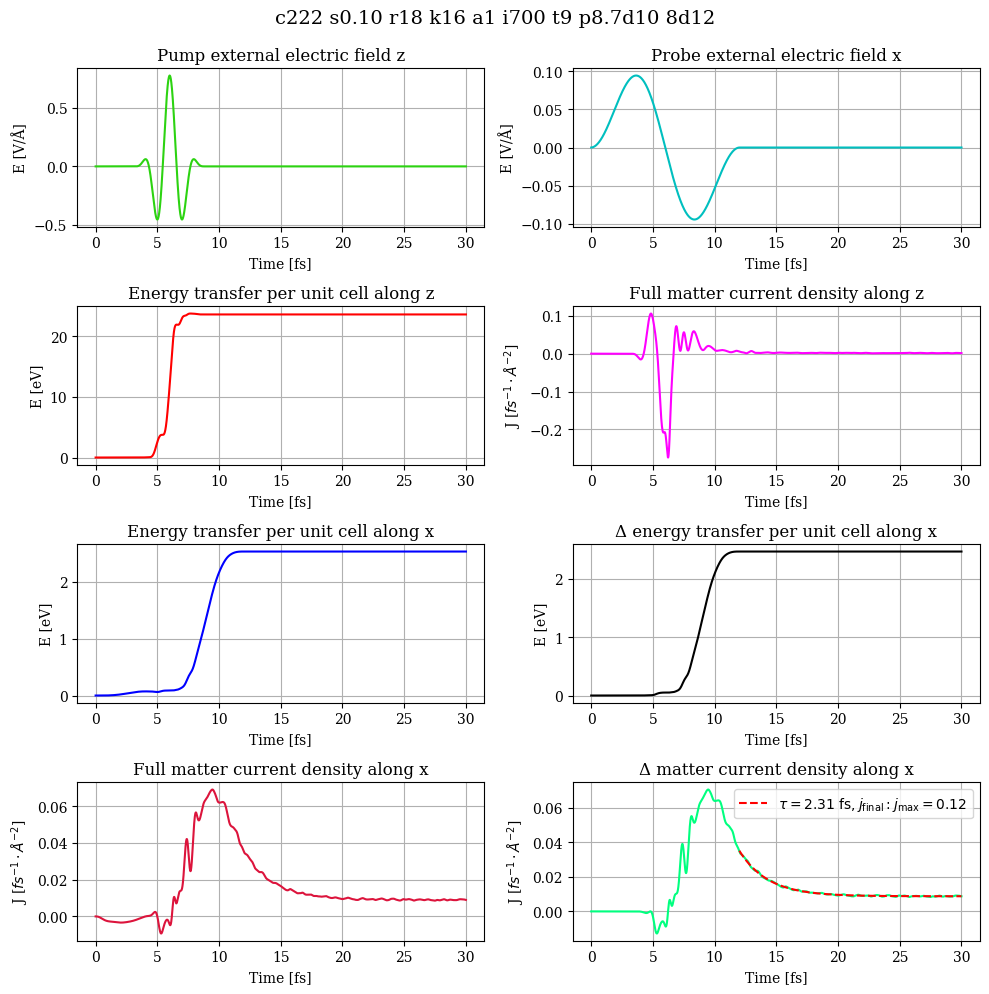

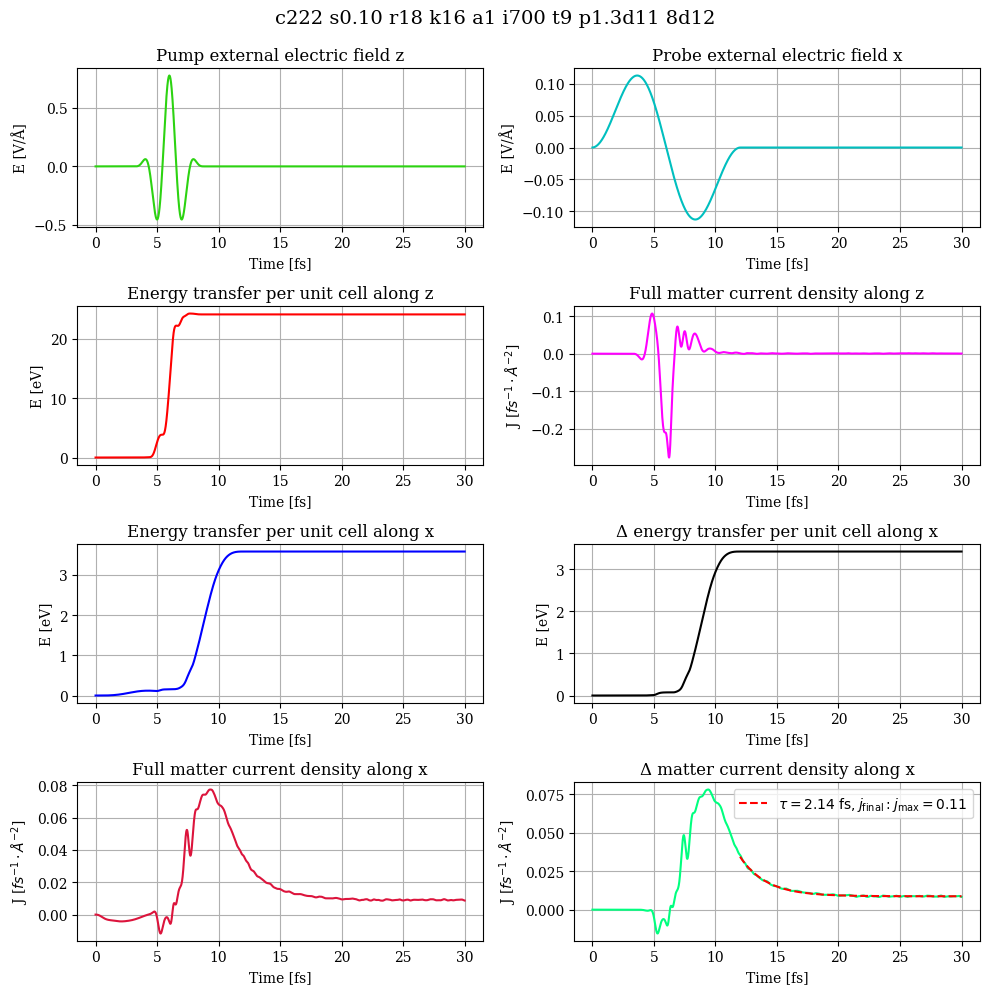

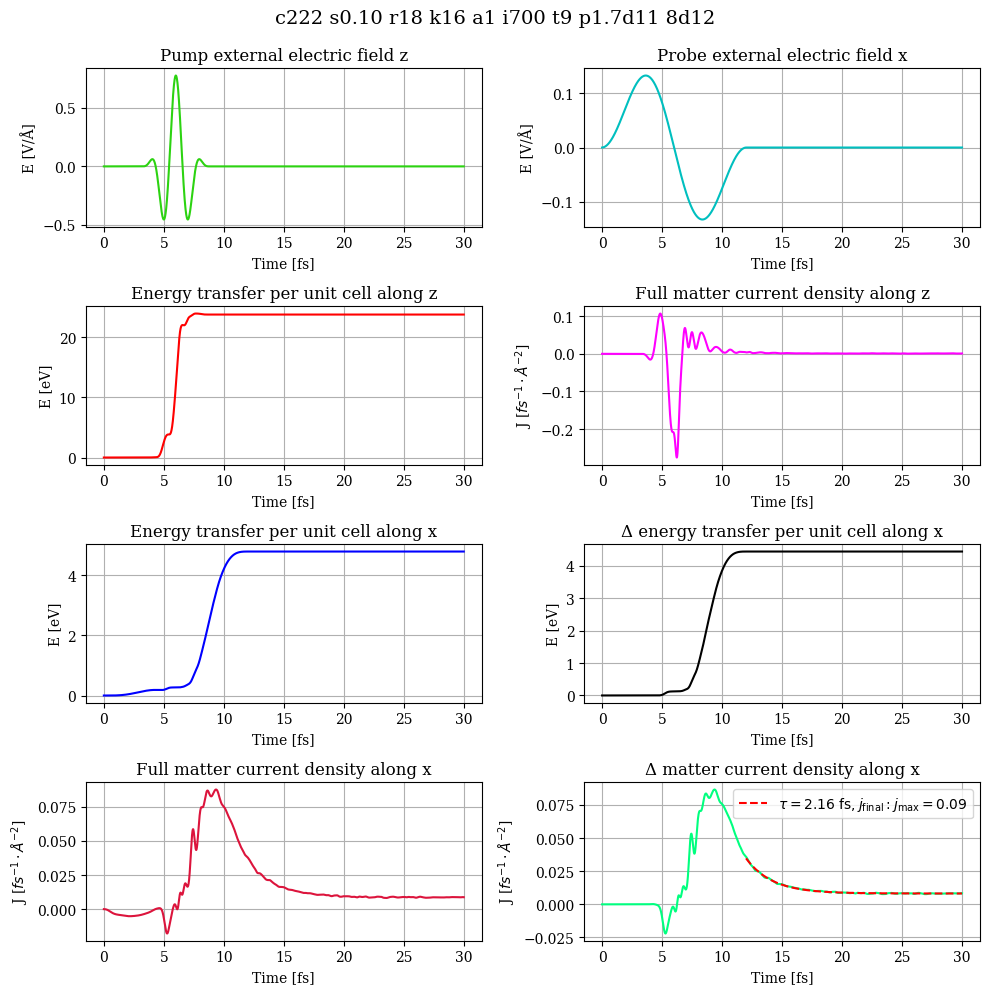

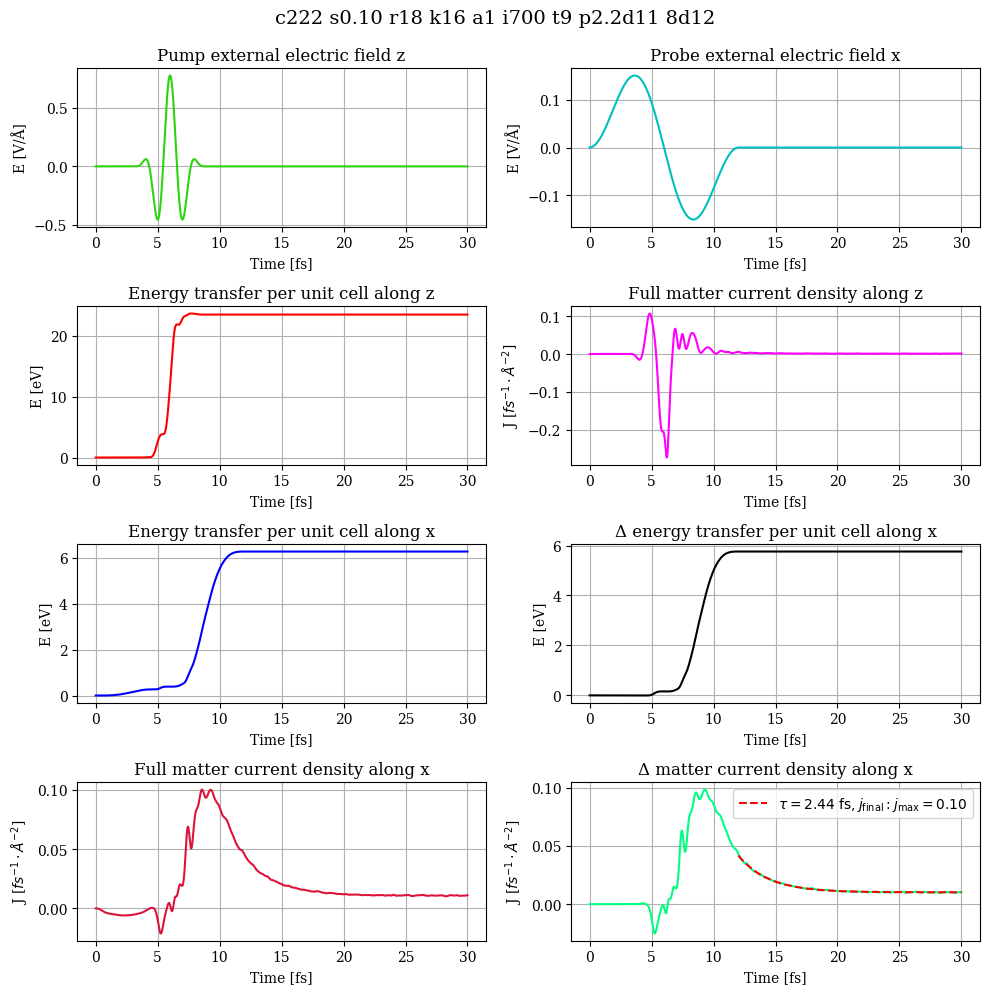

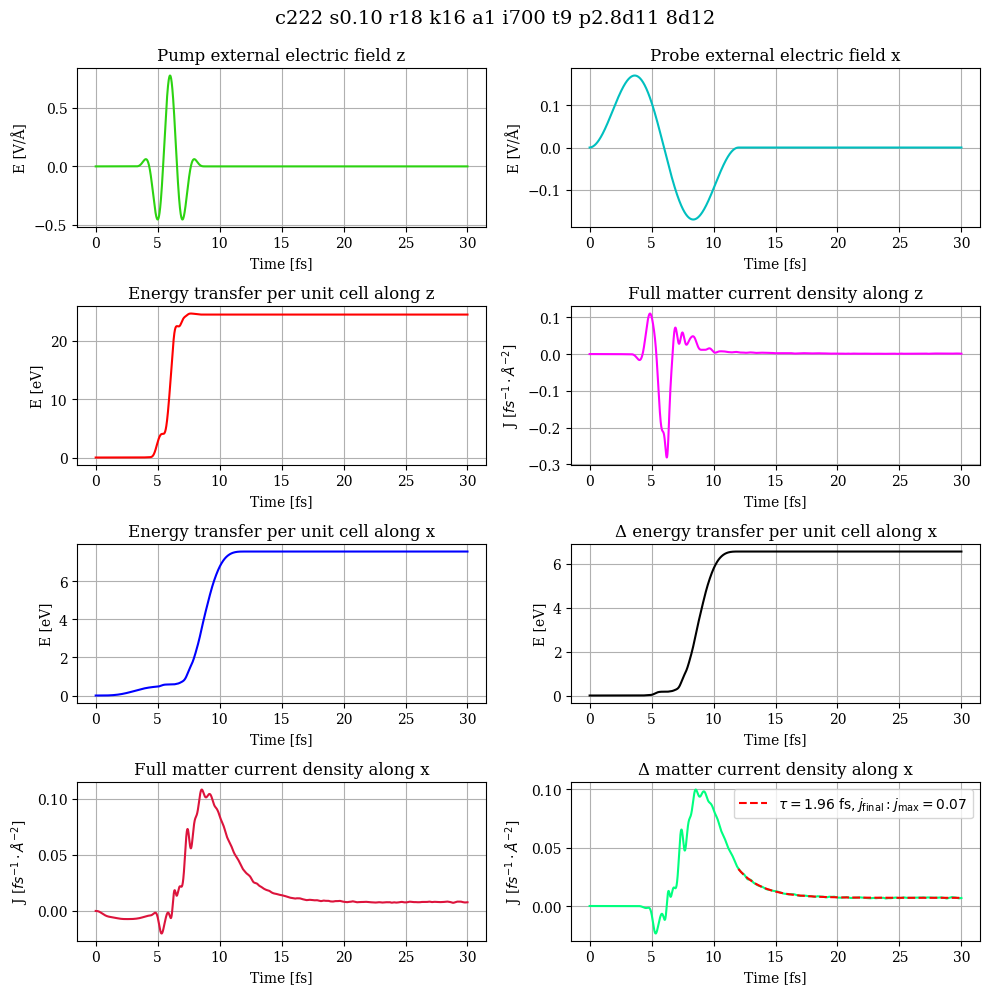

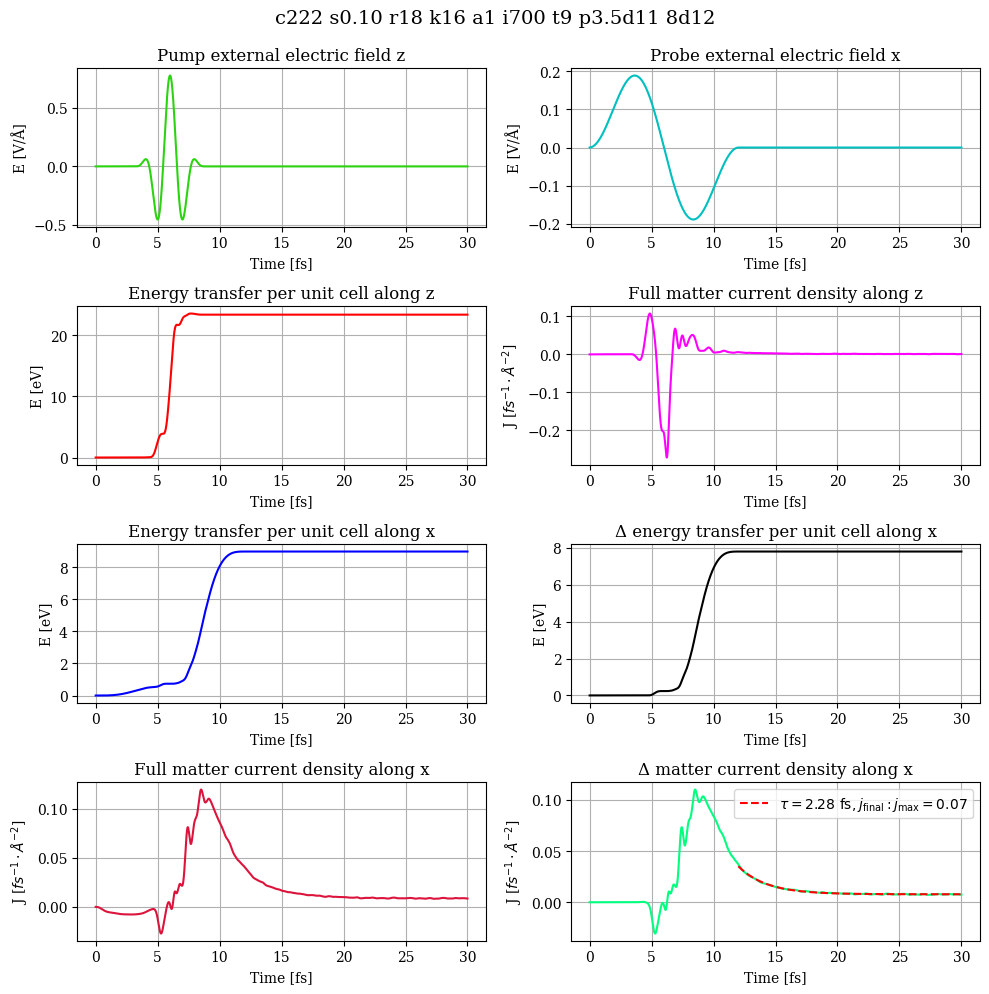

In [7]:
ax = 'z'

folders = [name for name in os.listdir('.') if os.path.isdir(os.path.join('.', name))]

# folders = [f for f in folders if f.startswith('c')]
folders = [f for f in folders 
           if f.startswith('c') 
           and os.path.isfile(os.path.join(f, 'probe_pulse_rt.data')) 
           and not os.path.isdir(os.path.join(f, 'restart'))]


# print(folders)


# Сортировка: сначала по c, потом по s, потом по k
sorted_folders = sorted(folders, key=lambda s: (extract_p(s), extract_c_num(s), extract_r_num(s), extract_s_num(s), extract_k_num(s), extract_a_num(s), extract_i_num(s)))


# In[74]:


alphas = []
taus = []
j_finals = []

j=0
for folder in sorted_folders:
    j=j+1
    alpha, tau, j0_final = plot_nonlinear_response_v4(folder, ax, j, "v1")
    alphas.append(alpha)
    taus.append(tau)
    j_finals.append(j0_final)


taus.insert(0, taus[0] + (taus[0]-taus[1])*alphas[0]/(alphas[1]-alphas[0]))
alphas.insert(0, 0)


# j=0
# for folder in sorted_folders:
#     j=j+1
#     alpha, tau = plot_nonlinear_response_v4(folder, ax, j, "v2", alphas, taus)
#     alphas.append(alpha)
#     taus.append(tau)

## draft

In [8]:
folder = sorted_folders[0]

In [9]:
# Загрузка данных, пропуская строки с комментариями (начинаются с #)
data_both = pd.read_csv(
    folder + '/both_pulses_rt.data',
    comment='#',
    delim_whitespace=True,
    header=None
)

data_probe = pd.read_csv(
    folder + '/probe_pulse_rt.data',
    comment='#',
    delim_whitespace=True,
    header=None
)

# Назначим читаемые имена колонкам
data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
    'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
    'Jm_x', 'Jm_y', 'Jm_z']

data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
    'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
    'Jm_x', 'Jm_y', 'Jm_z']


t = data_both['time_fs']

dt = np.diff(t, prepend=t[0])


Jm_both_z  =  data_both['Jm_z']

Jm_both_x  =  data_both['Jm_x']
Jm_probe_x =  data_probe['Jm_x']

Jm_both_y  =  data_both['Jm_y']
Jm_probe_y =  data_probe['Jm_y']


El_f_pump_z = data_both['E_ext_z']
El_f_probe_x = data_both['E_ext_x']

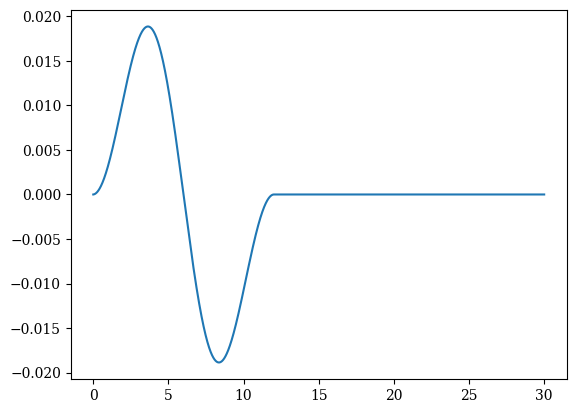

In [10]:
plt.plot(t, El_f_probe_x)

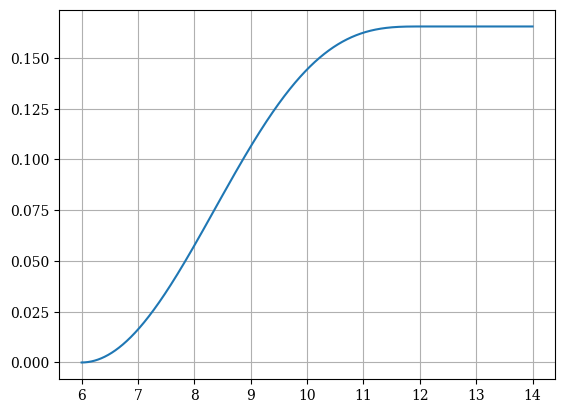

In [11]:
plt.plot(t[3000:7000], np.cumsum(-2.64*El_f_probe_x[3000:7000]*dt[3000:7000]))
plt.grid()

In [12]:
np.cumsum(2.64*El_f_probe_x[3000:]*dt[3000:])

3000    -6.745880e-08
3001    -2.698351e-07
3002    -6.071284e-07
3003    -1.079338e-06
3004    -1.686464e-06
             ...     
14995   -1.655154e-01
14996   -1.655154e-01
14997   -1.655154e-01
14998   -1.655154e-01
14999   -1.655154e-01
Name: E_ext_x, Length: 12000, dtype: float64

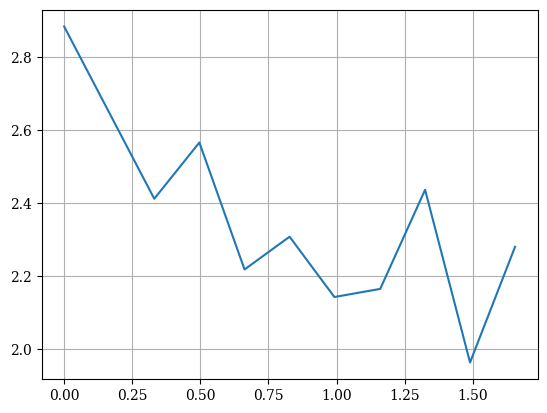

In [13]:
plt.plot(alphas, taus)
plt.grid()

In [14]:
taus

[np.float64(2.8842056798290496),
 np.float64(2.6478589224464497),
 np.float64(2.411851865801053),
 np.float64(2.566055017440829),
 np.float64(2.2178800771910723),
 np.float64(2.3077859247263808),
 np.float64(2.1423460661939697),
 np.float64(2.1646659798176198),
 np.float64(2.436337580741727),
 np.float64(1.9628716471952738),
 np.float64(2.280004213111804)]

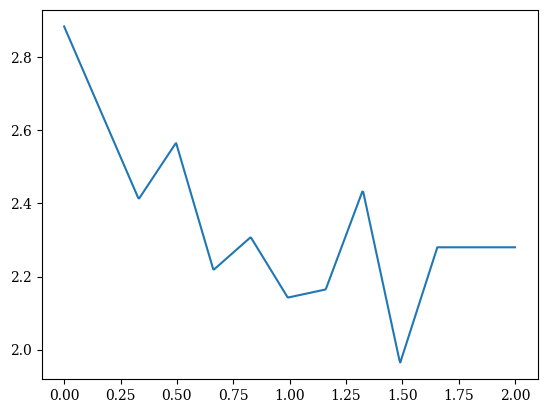

In [15]:
plt.plot(np.linspace(0, 2, 500), [tau_from_alpha(a, alphas, taus) for a in np.linspace(0, 2, 500)])

In [16]:
dt = 0.002
j0 = 0.2
j_final = 0.05

data_both = pd.read_csv(
    folder + '/both_pulses_rt.data',
    comment='#',
    delim_whitespace=True,
    header=None
)


data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
    'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
    'Jm_x', 'Jm_y', 'Jm_z']

t = data_both['time_fs']
El_f_probe_x = data_both['E_ext_x']

# --- Задаём поле в дискретных точках ---
t_array = np.array(t[m0_cut_1:])         # сетка времени
E_array = -np.array(El_f_probe_x[m0_cut_1:]) 


# --- Решение через явный шаг Эйлера ---

j_euler = np.zeros_like(t_array)
j_euler[0] = j0

for k in range(len(t_array)-1):
    j_euler[k+1] = j_euler[k] + dt * (-(j_euler[k]-j_final)/tau)

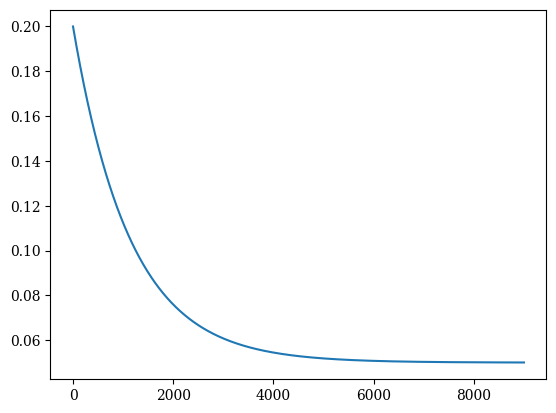

In [17]:
plt.plot(j_euler)

### J extract

In [18]:
folder = sorted_folders[0]

# Загрузка данных, пропуская строки с комментариями (начинаются с #)
data_both = pd.read_csv(
    folder + '/both_pulses_rt.data',
    comment='#',
    delim_whitespace=True,
    header=None
)


data_probe = pd.read_csv(
    folder + '/probe_pulse_rt.data',
    comment='#',
    delim_whitespace=True,
    header=None
)


# Назначим читаемые имена колонкам
data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
    'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
    'Jm_x', 'Jm_y', 'Jm_z']


data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
    'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
    'Jm_x', 'Jm_y', 'Jm_z']


t = data_both['time_fs']


Jm_both_z  =  data_both['Jm_z']

Jm_both_x  =  data_both['Jm_x']
Jm_probe_x =  data_probe['Jm_x']

Jm_both_y  =  data_both['Jm_y']
Jm_probe_y =  data_probe['Jm_y']

    
El_f_pump_z = data_both['E_ext_z']
El_f_probe_x = data_both['E_ext_x']


# 1:Time[fs] 2:Ac_ext_x[fs*V/Angstrom] 3:Ac_ext_y[fs*V/Angstrom] 4:Ac_ext_z[fs*V/Angstrom]
#5:E_ext_x[V/Angstrom] 6:E_ext_y[V/Angstrom] 7:E_ext_z[V/Angstrom] 8:Ac_tot_x[fs*V/Angstrom]
# 9:Ac_tot_y[fs*V/Angstrom] 10:Ac_tot_z[fs*V/Angstrom] 11:E_tot_x[V/Angstrom]
# 12:E_tot_y[V/Angstrom] 13:E_tot_z[V/Angstrom]  14:Jm_x[1/fs*Angstrom^2] 15:Jm_y[1/fs*Angstrom^2] 16:Jm_z[1/fs*Angstrom^2]


# Построим графики
plt.figure(figsize=(10, 5))

# Общий заголовок для всей фигуры
plt.suptitle(' '.join(re.split('[/_]', folder)), fontsize=14, y=0.99)



product_both_z = El_f_pump_z * Jm_both_z * volume
# Разность по времени
dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
integral_both_z = np.cumsum(product_both_z * dt)

product_both_x = El_f_probe_x * Jm_both_x * volume
# Разность по времени
dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
integral_both_x = np.cumsum(product_both_x * dt)

product_delta_x = El_f_probe_x * (Jm_both_x - Jm_probe_x) * volume
# Разность по времени
dt = np.diff(t, prepend=t[0])  # prepend чтобы сохранить размер
integral_delta_x = np.cumsum(product_delta_x * dt)


# # Разностный ток по x
# plt.subplot(1, 1, 1)
# plt.plot(t[::50], delta_Jm_x[::50], color='#00FF7F')
# plt.plot(t, delta_Jm_x, color='r')
# plt.xlabel('Time [fs]')
# plt.ylabel('J [$fs^{-1} \\cdot Å^{-2}$]')
# plt.title('Δ matter current density along x')
# plt.grid(True)
# plt.tight_layout()

<Figure size 1000x500 with 0 Axes>

### drude fit

181 181


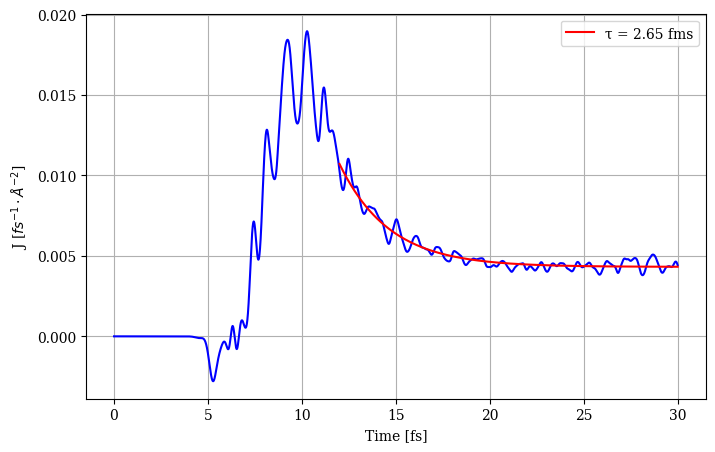

In [19]:
delta_Jm_x = Jm_both_x - Jm_probe_x

t_array_cut = np.array(t[m0_cut_1:])[::50]
j_exp = np.array(delta_Jm_x[m0_cut_1:])[::50]
# (dummy_t, j0, j_final, tau)
p0 = [0.03, 0.01, 6.65]   # начальные приближения (n, tau)
print(len(t_array_cut), len(j_exp))
popt, pcov = curve_fit(drude_current_v1, t_array_cut, j_exp, p0=p0)
j0, j_final, tau= popt
j_fit = drude_current_v1(0, j0, j_final, tau)

plt.figure(figsize=(8,5))
plt.plot(t, delta_Jm_x, color='b')
plt.plot(t_array_cut, j_fit, '-', label=f"τ = {tau:.2f} fms", color='r')
plt.xlabel("Time [fs]")
plt.ylabel("J [$fs^{-1} \\cdot Å^{-2}$]")
plt.legend()
plt.grid()
plt.show()



In [20]:
# t_array_cut = np.array(t[m0_cut_2:])[::50]
# j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]

# tau_global = tau
# j_final_global = j_final

# # === Фитирование ===
# # (dummy_t, j0, alpha, tau_global, j_final_global --- надо менять функцию чтобы все графики нормально строились)
# p0 = [0.03, 0.025, 0, 0]   # начальные приближения (n, tau)
# popt, pcov = curve_fit(drude_current_v2, t_array_cut, j_exp, p0=p0)

# j0, alpha = popt
# print("Оцененные параметры:")
# print("j0 =", j0)
# print("alpha =", alpha)

# # === Сравнение на графике ===
# j_fit = drude_current_v2(0, j0, alpha)

# plt.figure(figsize=(8,5))
# plt.plot(t, delta_Jm_x, color='b')
# plt.plot(t_array_cut, j_fit, '-', label=f"Drude: τ={tau_global:.2f}, α={alpha:.2f}", color='r')
# plt.xlabel("Time [fms]")
# plt.ylabel("J [$fs^{-1} \\cdot Å^{-2}$]")
# plt.legend()
# plt.grid()
# plt.show()

### drude func

In [21]:
# def generalized_drude_current_v2(dummy_t, j0, alpha, j_final, alphas, taus):

#     step_dt = 0.002

    
#     data_both = pd.read_csv(
#         folder + '/both_pulses_rt.data',
#         comment='#',
#         delim_whitespace=True,
#         header=None
#     )


#     data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
#         'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
#         'Jm_x', 'Jm_y', 'Jm_z']

#     t = data_both['time_fs']
#     El_f_probe_x = data_both['E_ext_x']

    
    
#     # --- Задаём поле в дискретных точках ---
#     t_array = np.array(t[m0_cut_2:])         # сетка времени
#     E_array = -np.array(El_f_probe_x[m0_cut_2:]) 
    
        
#     # --- Решение через явный шаг Эйлера ---
    
#     j_euler = np.zeros_like(t_array)
#     j_euler[0] = j0
    
#     for k in range(len(t_array)-1):
#         j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-j_final)/tau[k] + alpha * E_array[k])


#     return j_euler[::50]

In [22]:
# f_fixed = partial(f, z=z0)

# popt, pcov = curve_fit(f_fixed, (xdata, ydata), data)


In [23]:
def tau_from_alpha(alpha, alphas, taus):
    return np.interp(alpha, alphas, taus)

In [24]:
def generalized_drude_current_v2(dummy_t, j0, fit_alpha, arr_j_finals, arr_alphas, arr_taus, idx):

    
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']
    
    
    step_dt = 0.002
    
    m0_cut_2 = 3749
    
    dt = np.diff(t, prepend=t[0])
    
    
    alpha_E_t = np.cumsum(-2.64*El_f_probe_x[3000:]*dt[3000:])
    fit_alpha_E_t = alpha_E_t[749:]
    
    taus_fit = tau_from_alpha(fit_alpha_E_t, alphas, taus)
    
    
    
    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_2:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_2:]) 
    
        
    # --- Решение через явный шаг Эйлера ---
    
    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0
    
    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-arr_j_finals[idx])/taus_fit[k] + fit_alpha * E_array[k])

    
    return j_euler[::50]

In [25]:
def drude_current_v3_fixed_tau(dummy_t, j0, fit_alpha, arr_j_finals, arr_alphas, arr_taus, idx):

    
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']
    
    
    step_dt = 0.002
    
    m0_cut_2 = 3749
    
    dt = np.diff(t, prepend=t[0])
    
    
    alpha_E_t = np.cumsum(-2.64*El_f_probe_x[3000:]*dt[3000:])
    fit_alpha_E_t = alpha_E_t[749:]
    
    taus_fit = tau_from_alpha(fit_alpha_E_t, alphas, taus)
    
    
    
    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_2:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_2:]) 
    
        
    # --- Решение через явный шаг Эйлера ---
    
    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0
    
    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-arr_j_finals[idx])/taus_fit[-1] + fit_alpha * E_array[k])

    
    return j_euler[::50]

In [26]:
# taus_fit[-1]

In [27]:
for i in range(5):
    print(i)

0
1
2
3
4


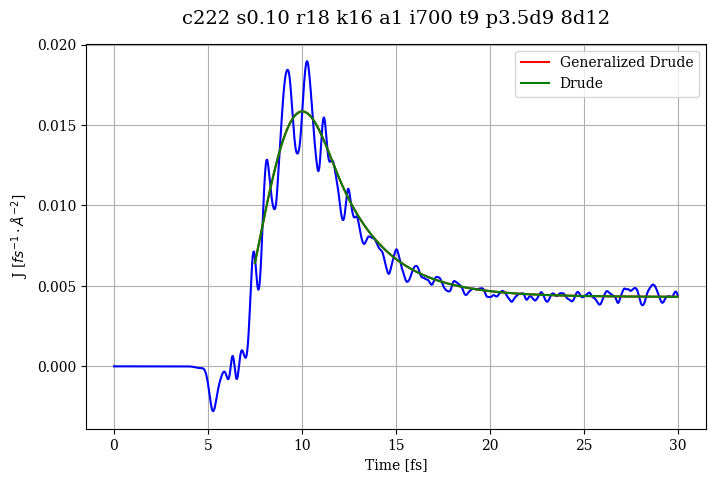

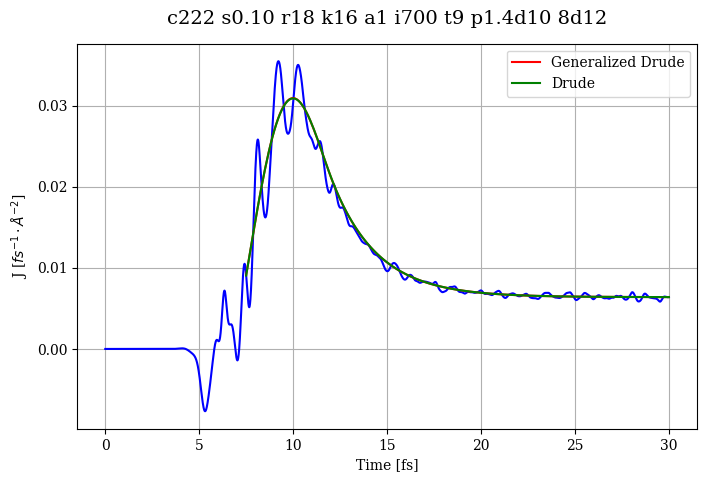

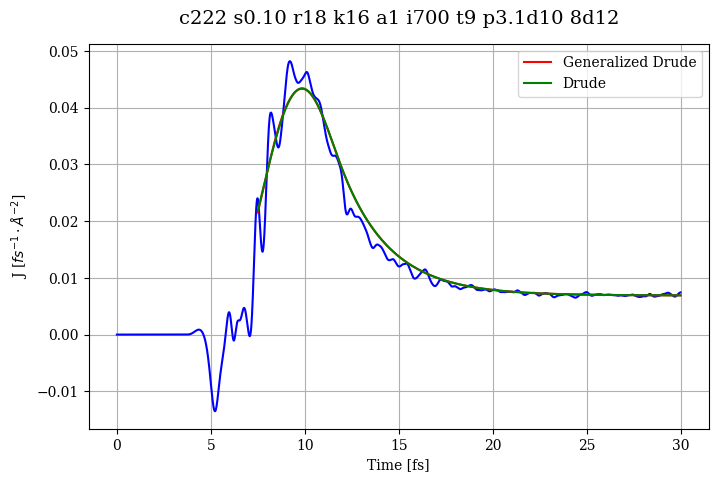

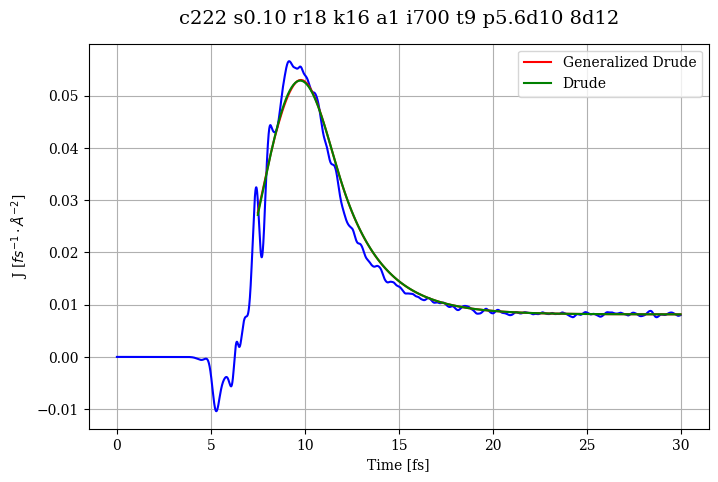

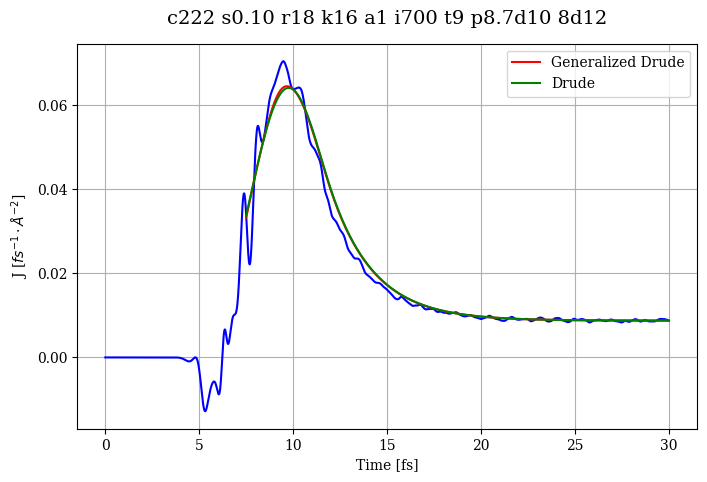

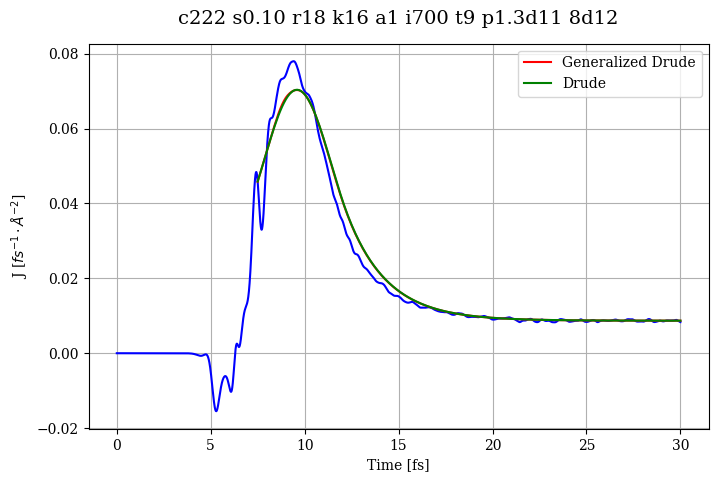

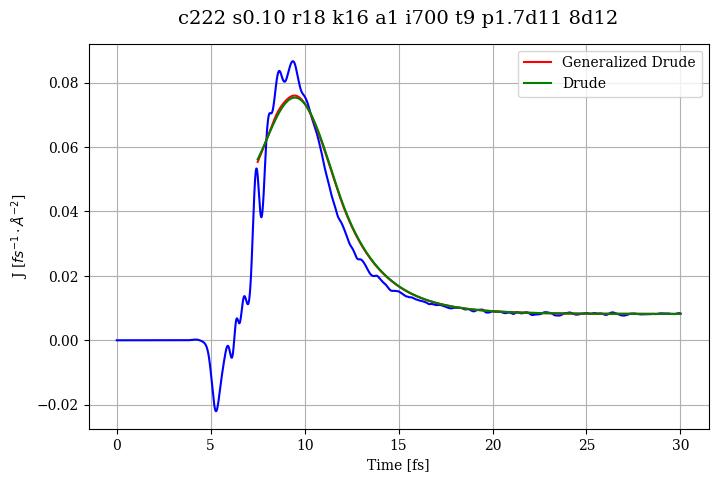

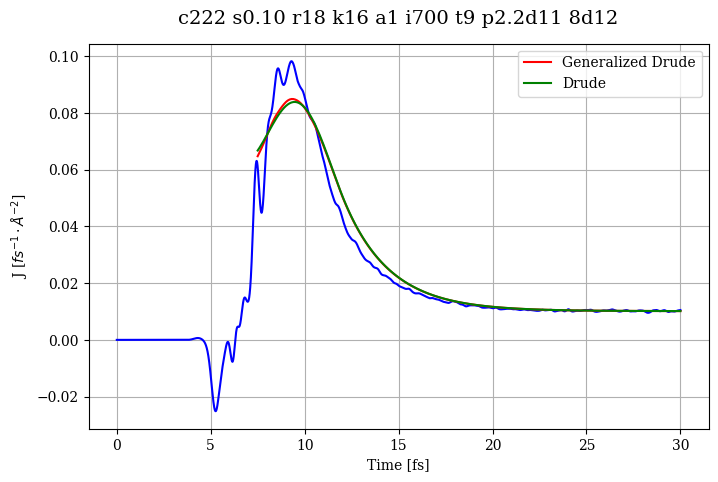

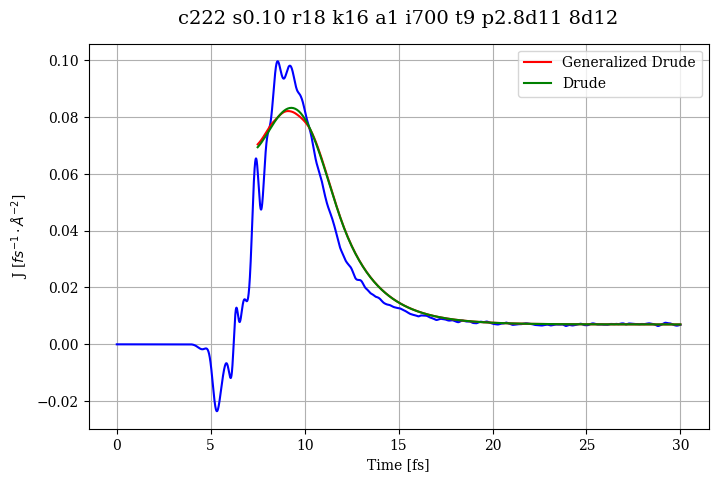

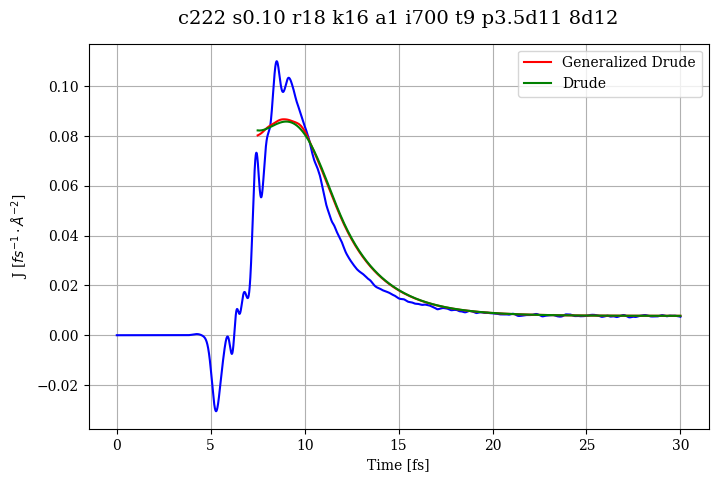

In [28]:
fit_alphas = []

for num_folder in range(10):
    
    folder = sorted_folders[num_folder]
    
    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_probe = pd.read_csv(
        folder + '/probe_pulse_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    # Назначим читаемые имена колонкам
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    t = data_both['time_fs']
    
    
    Jm_both_z  =  data_both['Jm_z']
    
    Jm_both_x  =  data_both['Jm_x']
    Jm_probe_x =  data_probe['Jm_x']
    
    Jm_both_y  =  data_both['Jm_y']
    Jm_probe_y =  data_probe['Jm_y']
    
        
    El_f_pump_z = data_both['E_ext_z']
    El_f_probe_x = data_both['E_ext_x']
    
    
    fixed_generalized_drude_current_v2 = partial(generalized_drude_current_v2, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    fixed_drude_current_v3_fixed_tau = partial(drude_current_v3_fixed_tau, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    
    delta_Jm_x = Jm_both_x - Jm_probe_x
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03, 0.2]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_generalized_drude_current_v2, t_array_cut, j_exp, p0=p0)
    j0, fit_alpha = popt
    j_fit = fixed_generalized_drude_current_v2(0, j0, fit_alpha)
    
    plt.figure(figsize=(8,5))
    plt.title(' '.join(re.split('[/_]', folder)), fontsize=14, y=1.03)
    plt.plot(t, delta_Jm_x, color='b')
    plt.plot(t_array_cut, j_fit, '-', label='Generalized Drude', color='r')
    plt.xlabel("Time [fs]")
    plt.ylabel("J [$fs^{-1} \\cdot Å^{-2}$]")
    
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03, 0.2]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_drude_current_v3_fixed_tau, t_array_cut, j_exp, p0=p0)
    j0, fit_alpha = popt
    j_fit = fixed_drude_current_v3_fixed_tau(0, j0, fit_alpha)

    fit_alphas.append(fit_alpha)
    
    
    plt.plot(t_array_cut, j_fit, '-', label='Drude', color='g')
    plt.legend()
    plt.grid()
    
    
    
    # plt.show()
    
    plt.savefig("drude/" + str(num_folder+1)+ '_' + folder + ".png", dpi=200)

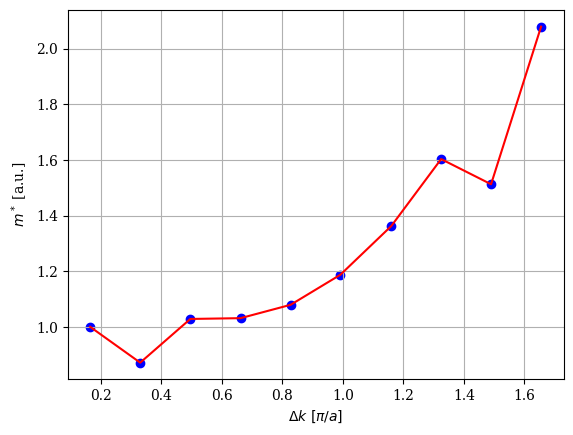

In [29]:
plt.scatter(alphas[1:], 1/np.array(fit_alphas)*fit_alphas[0], color='b')
plt.plot(alphas[1:], 1/np.array(fit_alphas)*fit_alphas[0], color='r')
plt.xlabel(r'$\Delta k \, \, [\pi/a]$')
plt.ylabel(r'$m^*$ [a.u.]')
plt.grid()

a = 0.1845130709475982
b = 0.4362954266510967
c = 2.293136235384796


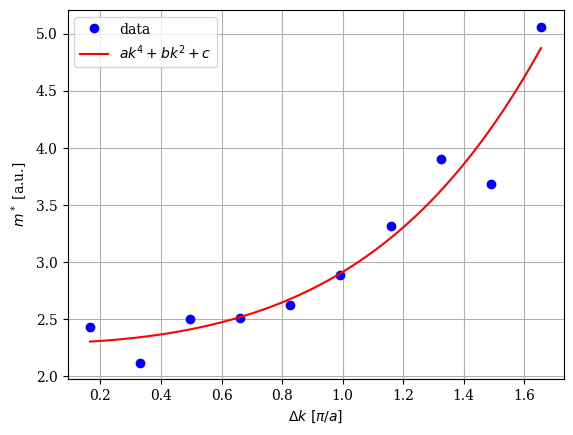

In [30]:
k_data = np.array(alphas[1:])
y_data = 1 / np.array(fit_alphas)

# замена переменной
u = k_data**2

# фит квадратичным полиномом по u
coeffs = np.polyfit(u, y_data, 2)

# распаковка коэффициентов
a, b, c = coeffs

print("a =", a)
print("b =", b)
print("c =", c)

# кривая для отображения
k_fit = np.linspace(k_data.min(), k_data.max(), 400)
y_fit = a*k_fit**4 + b*k_fit**2 + c

# график
plt.figure()
plt.plot(k_data, y_data, 'o', label='data', color='b')
plt.plot(k_fit, y_fit, '-', label=r"$a k^4 + b k^2 + c$", color='r')
plt.xlabel(r'$\Delta k \, \, [\pi/a]$')
plt.ylabel(r'$m^*$ [a.u.]')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# сделать полиномную зависимость в качестве свободных параметров и фитануть самый последний график!!
# если теория верна, то предыдущие фитанутся на ура!!!!!!!!!!!

In [32]:
6*a*c

np.float64(2.538681653352379)

In [33]:
6*a*c/b**2

np.float64(13.336655197486653)

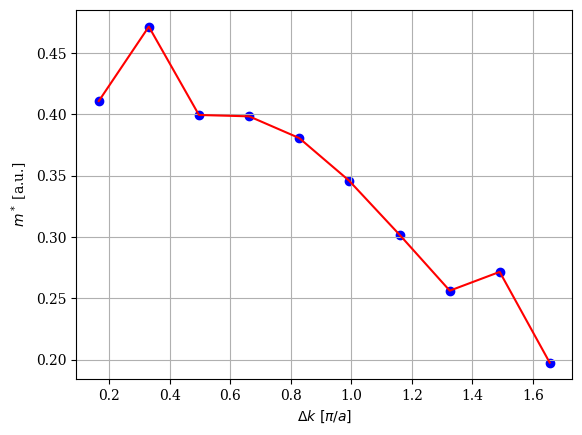

In [34]:
# alpha суть обратная эффективная масса (с точностью до коэффициентов)

plt.scatter(alphas[1:], np.array(fit_alphas), color='b')
plt.plot(alphas[1:], np.array(fit_alphas), color='r')
plt.xlabel(r'$\Delta k \, \, [\pi/a]$')
plt.ylabel(r'$m^*$ [a.u.]')
plt.grid()

In [35]:
# очень хуевыё обозначения, но alpha это смещение волнового вектора, а fit_alpha это обратная эффективная масса
# а ещё у меня сдвиг в массиве по alpha так как я добавил руками нулевой элемент

def fit_alpha_from_alpha(alpha, alphas, fit_alphas):
    return np.interp(alpha, alphas, fit_alphas)

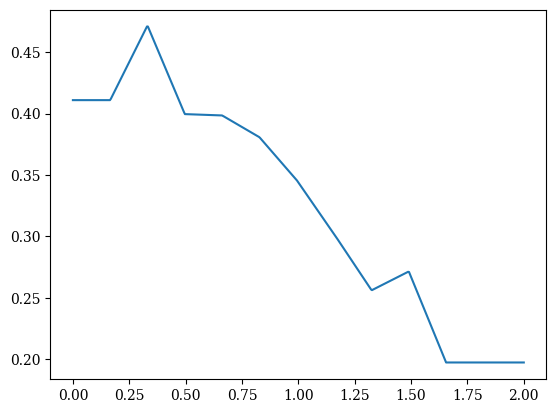

In [36]:
plt.plot(np.linspace(0, 2, 500), [fit_alpha_from_alpha(a, alphas[1:], fit_alphas) for a in np.linspace(0, 2, 500)])

## $m^*$ dependence Drude

In [37]:
def generalized_drude_current_v5_tau_mass(dummy_t, j0, arr_fit_alphas, arr_j_finals, arr_alphas, arr_taus, idx):

    
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']
    
    
    step_dt = 0.002
    
    m0_cut_2 = 3749
    
    dt = np.diff(t, prepend=t[0])
    
    
    alpha_E_t = np.cumsum(-2.64*El_f_probe_x[3000:]*dt[3000:])
    fit_alpha_E_t = alpha_E_t[749:]
    
    taus_fit = tau_from_alpha(fit_alpha_E_t, alphas, taus)

    alpha_fit = fit_alpha_from_alpha(fit_alpha_E_t, alphas[1:], arr_fit_alphas)
    
    
    
    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_2:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_2:]) 
    
        
    # --- Решение через явный шаг Эйлера ---
    
    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0
    
    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-arr_j_finals[idx])/taus_fit[k] + alpha_fit[k] * E_array[k])

    
    return j_euler[::50]

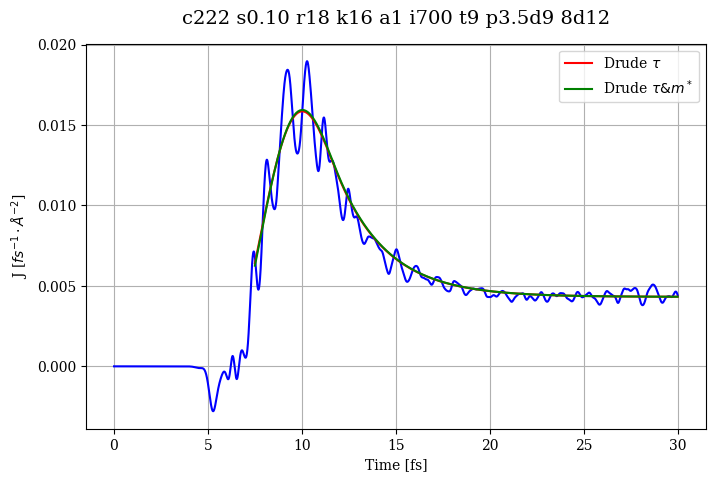

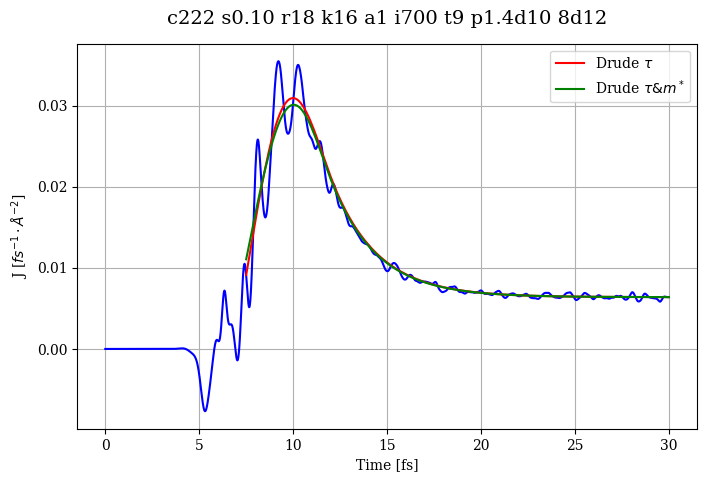

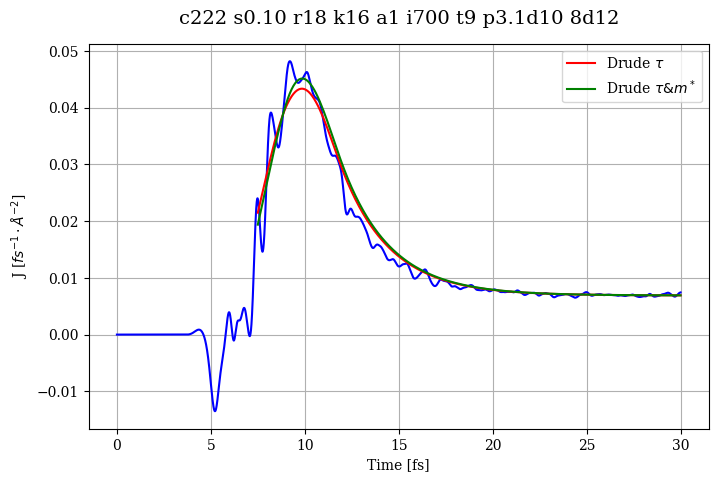

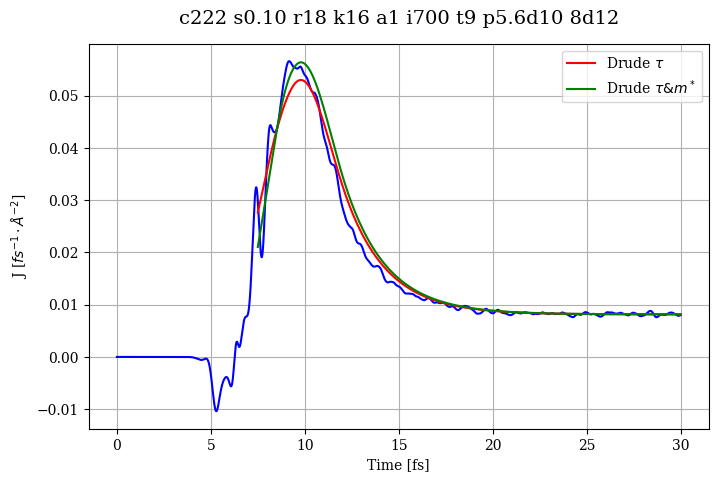

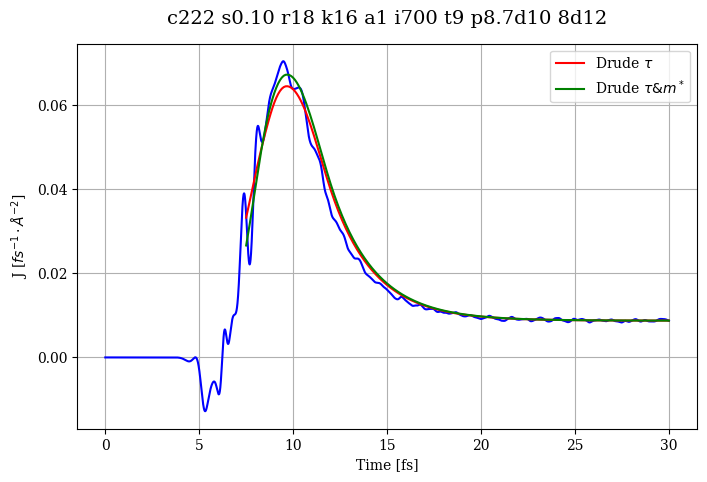

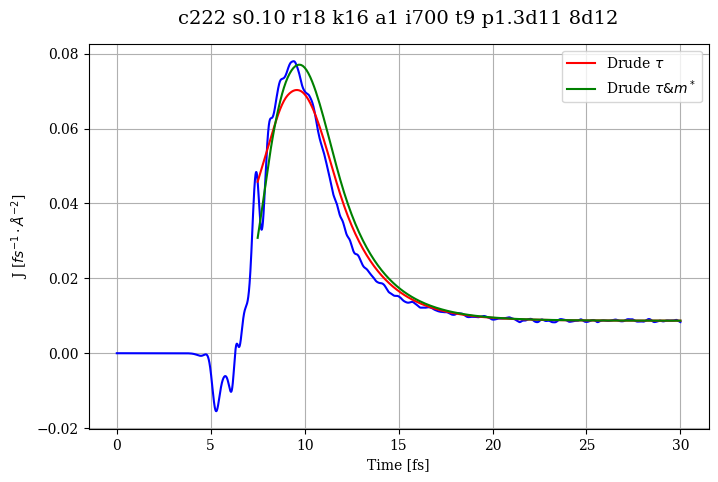

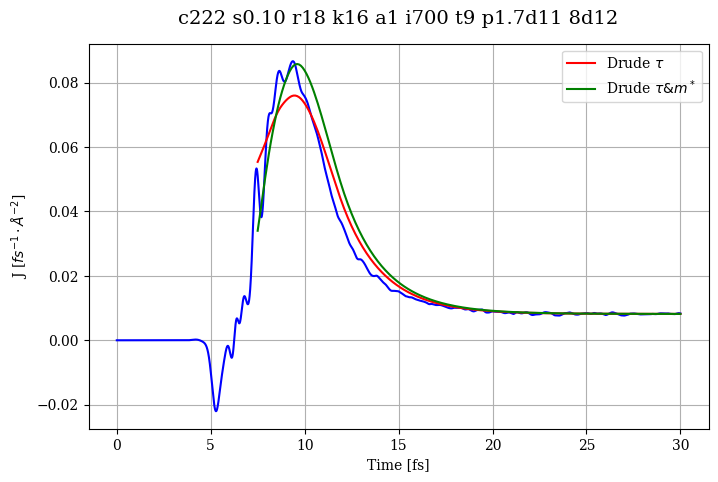

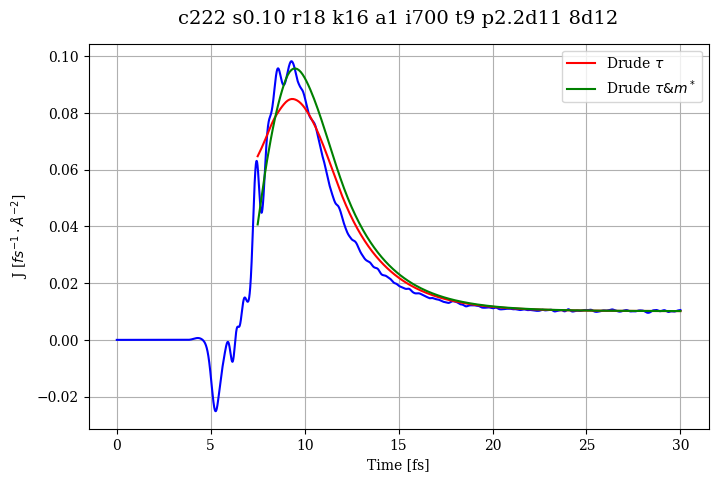

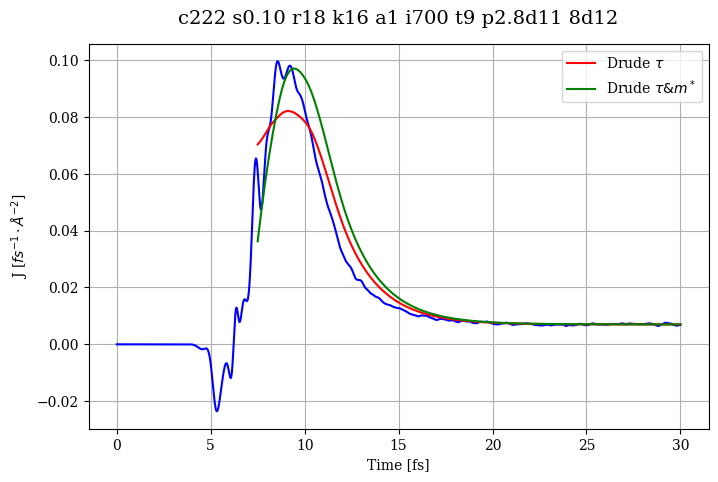

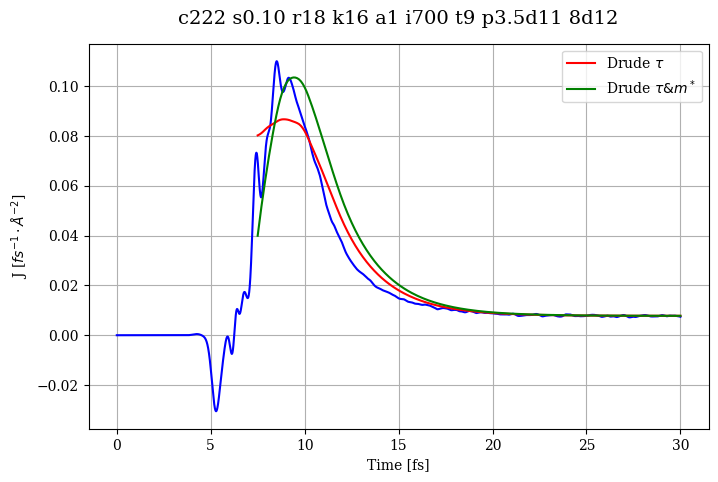

In [38]:
for num_folder in range(10):
    
    folder = sorted_folders[num_folder]
    
    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_probe = pd.read_csv(
        folder + '/probe_pulse_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    # Назначим читаемые имена колонкам
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    t = data_both['time_fs']
    
    
    Jm_both_z  =  data_both['Jm_z']
    
    Jm_both_x  =  data_both['Jm_x']
    Jm_probe_x =  data_probe['Jm_x']
    
    Jm_both_y  =  data_both['Jm_y']
    Jm_probe_y =  data_probe['Jm_y']
    
        
    El_f_pump_z = data_both['E_ext_z']
    El_f_probe_x = data_both['E_ext_x']
    
    
    fixed_generalized_drude_current_v2 = partial(generalized_drude_current_v2, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    fixed_generalized_drude_current_v5_tau_mass = partial(generalized_drude_current_v5_tau_mass, arr_fit_alphas=fit_alphas, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    
    delta_Jm_x = Jm_both_x - Jm_probe_x
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03, 0.2]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_generalized_drude_current_v2, t_array_cut, j_exp, p0=p0)
    j0, fit_alpha = popt
    j_fit = fixed_generalized_drude_current_v2(0, j0, fit_alpha)
    
    plt.figure(figsize=(8,5))
    plt.title(' '.join(re.split('[/_]', folder)), fontsize=14, y=1.03)
    plt.plot(t, delta_Jm_x, color='b')
    plt.plot(t_array_cut, j_fit, '-', label=r'Drude $\tau$', color='r')
    plt.xlabel("Time [fs]")
    plt.ylabel("J [$fs^{-1} \\cdot Å^{-2}$]")
    
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_generalized_drude_current_v5_tau_mass, t_array_cut, j_exp, p0=p0)
    j0 = popt
    j_fit = fixed_generalized_drude_current_v5_tau_mass(0, j0)
    
    
    plt.plot(t_array_cut, j_fit, '-', label=r'Drude $\tau & m^*$', color='g')
    plt.legend()
    plt.grid()
    
    
    
    # plt.show()
    
    plt.savefig("drude_mass/" + str(num_folder+1)+ '_' + folder + ".png", dpi=200)

## general $m^*$ dependence adjustment

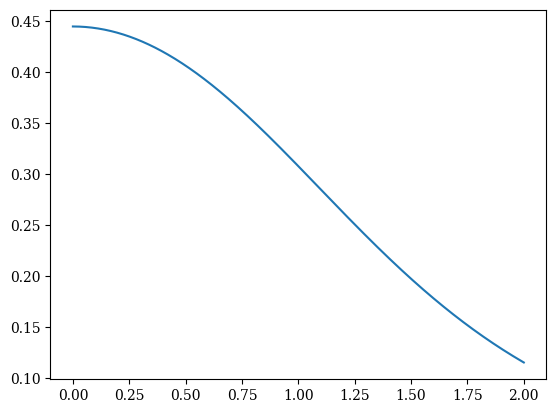

In [41]:
plt.plot(np.linspace(0, 2, 500), [effecive_mass_model(a, 0.2, 0.8, 2.25) for a in np.linspace(0, 2, 500)])

In [42]:
def effecive_mass_model(alpha, a, b, c):
    return 1/(a * alpha**4 + b * alpha**2 + c)

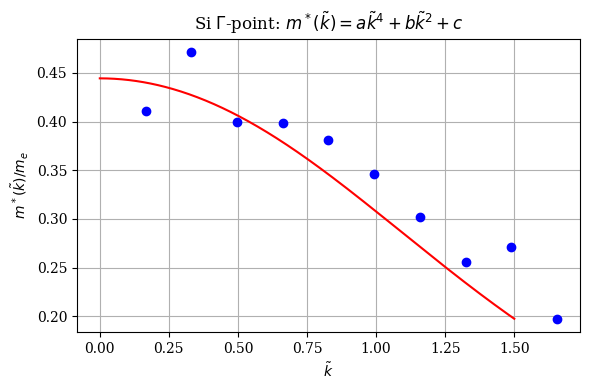

In [43]:
# коэффициенты разложения m*(k̃) = a k^4 + b k^2 + c
a = 0.2
b = 0.8
c = 2.25

# диапазон k̃ от 0 до 2
k_tilde = np.linspace(0.0, 1.5, 400)

# эффективная масса
m_eff = 1/(a * k_tilde**4 + b * k_tilde**2 + c)

# построение графика
plt.figure(figsize=(6, 4))
plt.plot(k_tilde, m_eff, color='r')
plt.plot(k_data, fit_alphas, 'o', label='data', color='b')
plt.xlabel(r'$\tilde{k}$')
plt.ylabel(r'$m^*(\tilde{k})/m_e$')
plt.title(r'Si $\Gamma$-point: $m^*(\tilde{k}) = a\tilde{k}^4 + b\tilde{k}^2 + c$')
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
def effecive_mass_model(alpha, a, b, c):
    return 1/(a**2 * alpha**4 + b**2 * alpha**8 + c)

In [63]:
def generalized_drude_current_v6_tau_mass_adjustment(dummy_t, j0, a, b, c, arr_j_finals, arr_alphas, arr_taus, idx):

    
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    t = data_both['time_fs']
    El_f_probe_x = data_both['E_ext_x']
    
    
    step_dt = 0.002
    
    m0_cut_2 = 3749
    
    dt = np.diff(t, prepend=t[0])
    
    
    alpha_E_t = np.cumsum(-2.64*El_f_probe_x[3000:]*dt[3000:])
    fit_alpha_E_t = alpha_E_t[749:]
    
    taus_fit = tau_from_alpha(fit_alpha_E_t, alphas, taus)

    alpha_fit = np.array(effecive_mass_model(fit_alpha_E_t, a, b, c))
    
    
    
    # --- Задаём поле в дискретных точках ---
    t_array = np.array(t[m0_cut_2:])         # сетка времени
    E_array = -np.array(El_f_probe_x[m0_cut_2:]) 
    
        
    # --- Решение через явный шаг Эйлера ---
    
    j_euler = np.zeros_like(t_array)
    j_euler[0] = j0
    
    for k in range(len(t_array)-1):
        j_euler[k+1] = j_euler[k] + step_dt * (-(j_euler[k]-arr_j_finals[idx])/taus_fit[k] + alpha_fit[k] * E_array[k])

    
    return j_euler[::50]

51.44818635161733 0.3 1.9699039681110382
-3.777842125682178 -97.81079110449336 1.9627919219927212
-0.0003199684987412925 35.46469262352136 1.9749291760249605
1.9879302395448906 11.696590103623246 2.0806997730225567
1.591349273307941 4.028329995002553 2.048327884484717
1.2354431951257605 3.002370830531085 2.154865757440301
1.4673426000935441 1.7283565826025766 2.1001867839290465
0.9962024794679795 1.2026043116827765 2.1579320437912757
0.000738526563519264 1.4976434439931054 2.2657642407254266
0.677606733720906 0.9864626306336783 2.332866964886777


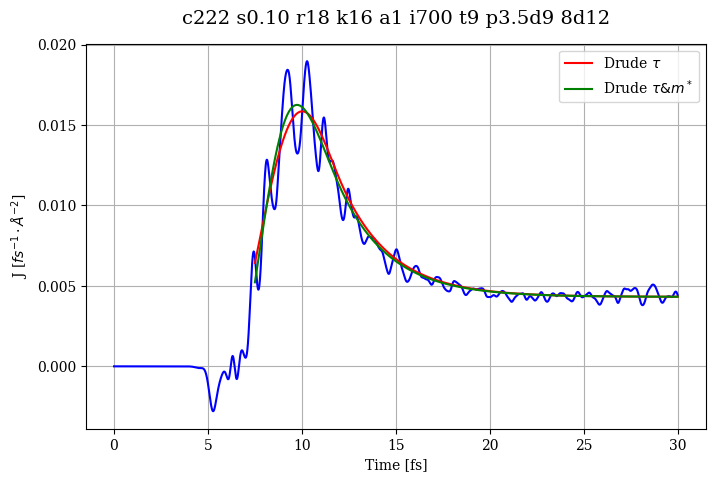

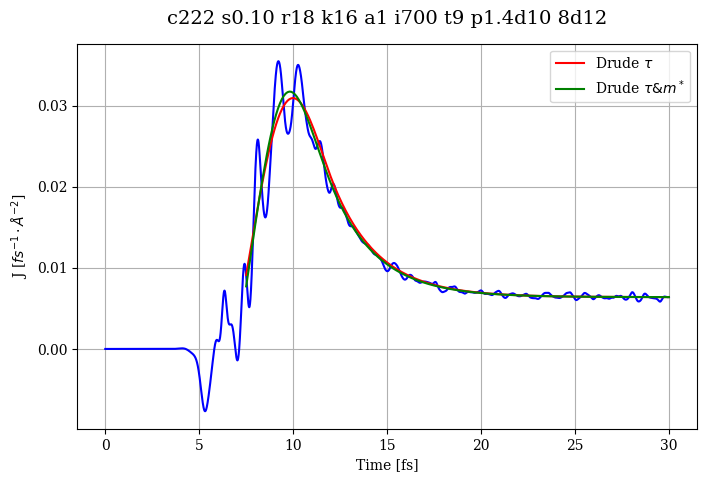

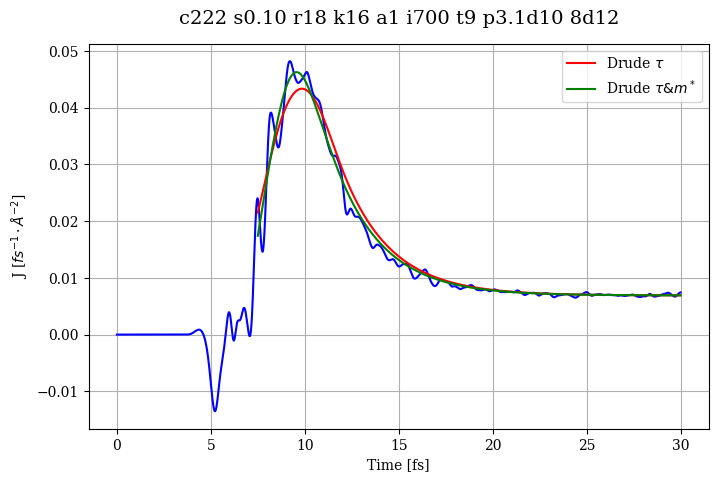

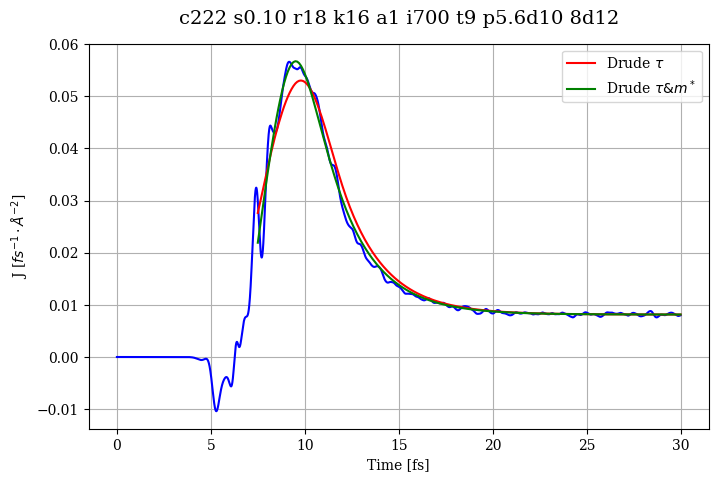

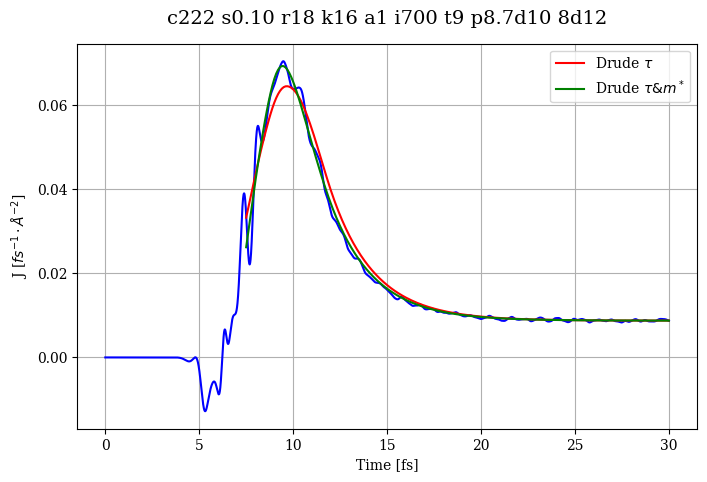

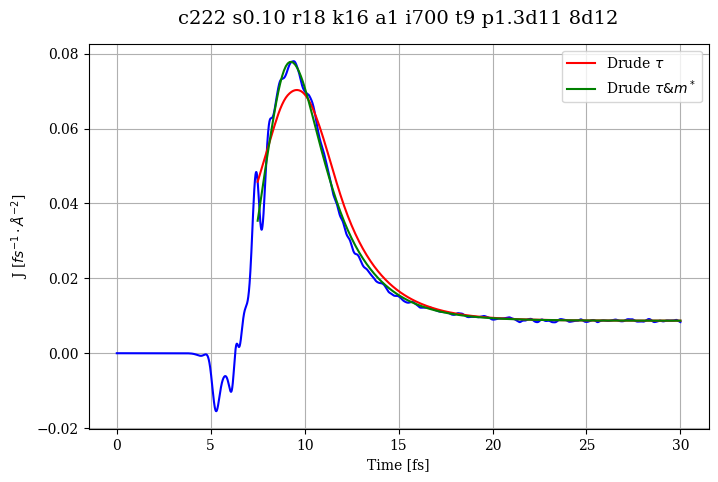

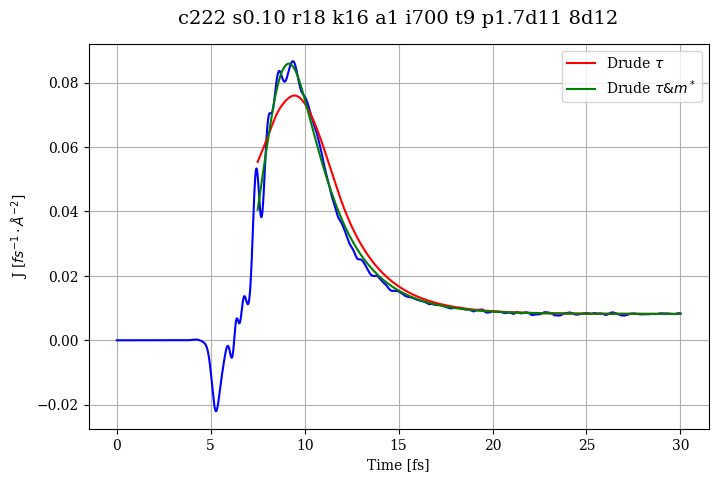

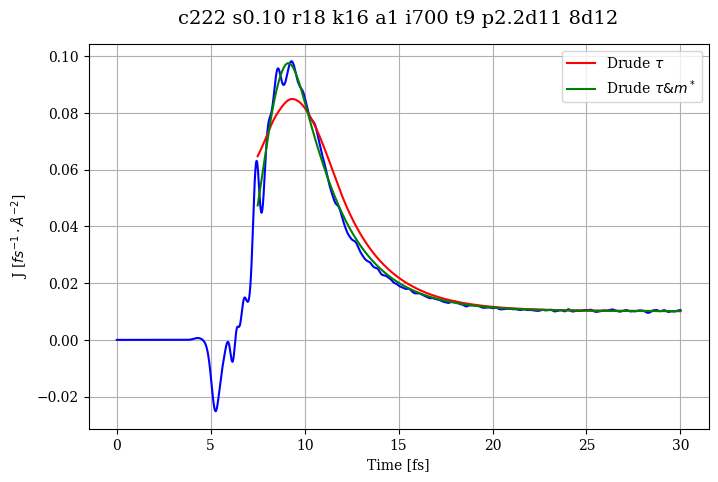

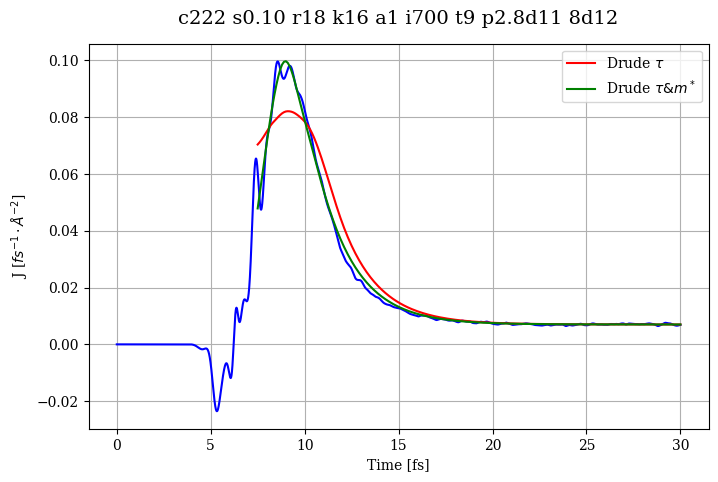

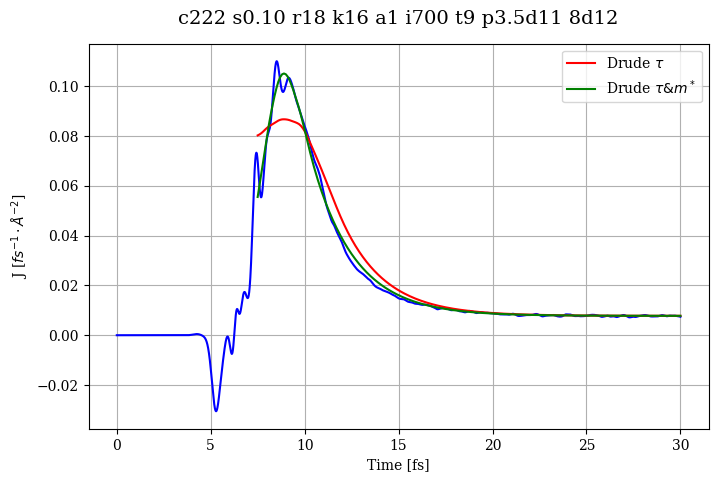

In [64]:
for num_folder in range(10):
    
    folder = sorted_folders[num_folder]
    
    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data_both = pd.read_csv(
        folder + '/both_pulses_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    data_probe = pd.read_csv(
        folder + '/probe_pulse_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    
    # Назначим читаемые имена колонкам
    data_both.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    data_probe.columns = ['time_fs', 'Ac_ext_x', 'Ac_ext_y', 'Ac_ext_z', 'E_ext_x', 'E_ext_y', 'E_ext_z',         
        'Ac_tot_x', 'Ac_tot_y', 'Ac_tot_z', 'E_tot_x', 'E_tot_y', 'E_tot_z',         
        'Jm_x', 'Jm_y', 'Jm_z']
    
    
    t = data_both['time_fs']
    
    
    Jm_both_z  =  data_both['Jm_z']
    
    Jm_both_x  =  data_both['Jm_x']
    Jm_probe_x =  data_probe['Jm_x']
    
    Jm_both_y  =  data_both['Jm_y']
    Jm_probe_y =  data_probe['Jm_y']
    
        
    El_f_pump_z = data_both['E_ext_z']
    El_f_probe_x = data_both['E_ext_x']
    
    
    fixed_generalized_drude_current_v2 = partial(generalized_drude_current_v2, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    fixed_generalized_drude_current_v6_tau_mass_adjustment = partial(generalized_drude_current_v6_tau_mass_adjustment, arr_j_finals=j_finals, arr_alphas=alphas, arr_taus=taus, idx=num_folder)
    
    
    
    delta_Jm_x = Jm_both_x - Jm_probe_x
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03, 0.2]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_generalized_drude_current_v2, t_array_cut, j_exp, p0=p0)
    j0, fit_alpha = popt
    j_fit = fixed_generalized_drude_current_v2(0, j0, fit_alpha)
    
    plt.figure(figsize=(8,5))
    plt.title(' '.join(re.split('[/_]', folder)), fontsize=14, y=1.03)
    plt.plot(t, delta_Jm_x, color='b')
    plt.plot(t_array_cut, j_fit, '-', label=r'Drude $\tau$', color='r')
    plt.xlabel("Time [fs]")
    plt.ylabel("J [$fs^{-1} \\cdot Å^{-2}$]")
    
    
    t_array_cut = np.array(t[m0_cut_2:])[::50]
    j_exp = np.array(delta_Jm_x[m0_cut_2:])[::50]
    # (dummy_t, j0, fit_alpha, j_final)
    p0 = [0.03, 0.3, 0.3, 2.25]   # начальные приближения (n, tau)
    # print(len(t_array_cut), len(j_exp))
    popt, pcov = curve_fit(fixed_generalized_drude_current_v6_tau_mass_adjustment, t_array_cut, j_exp, p0=p0)
    j0, a, b, c = popt
    j_fit = fixed_generalized_drude_current_v6_tau_mass_adjustment(0, j0, a, b, c)
    
    
    plt.plot(t_array_cut, j_fit, '-', label=r'Drude $\tau & m^*$', color='g')
    plt.legend()
    plt.grid()
    print(a, b, c)
    
    
    
    # plt.show()
    
    plt.savefig("drude_mass_adj/" + str(num_folder+1)+ '_' + folder + ".png", dpi=200)

In [101]:
## ОТЛИЧНО!!!!!!

# теперь нужно: сделать модель друде с фиксированным тау (поскольку эффективная масса меняется гораздо сильнее)
# фитануть для 10 графика и ту же модель эффективной массы применить к остальным девяти!!!

In [132]:
arr_abc = np.array([
    [51.44852652363333,   0.002800517245639955,   1.9699130696506988],
    [9.595837015106747,  -0.0022991803011109214,  1.8939453252416838],
    [6.580627689837693,  -0.001851051723098034,   1.8271510547827274],
    [4.3006178577167775,  2.7131263439759165e-05, 1.9256504037054758],
    [2.635357890804211,  -0.000138357768097919,  1.928097813768306],
    [2.4134131406329313,  0.00027550113557039003,1.959032905731763],
    [2.1367577501358723,  0.0004803278221159166, 1.9250201858680218],
    [1.7067696138016695, -2.8656481812511253e-05,1.9285626466666483],
    [1.8155595768997135, -0.0006579145946586529,1.8261835080838662],
    [1.599755423001538,  -0.0008469704557168061,1.9400430051222042],
])

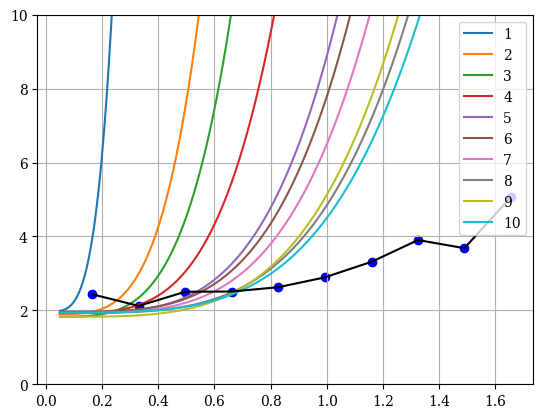

In [134]:
num_tuple=0
for (a0, b0, c0) in arr_abc:
    num_tuple+=1
    plt.plot(np.linspace(0.05, 1.5, 500), [1/effecive_mass_model(a, a0, b0, c0) for a in np.linspace(0.05, 1.5, 500)], label=num_tuple)
    plt.ylim(0, 10)
    

plt.grid()
plt.legend()
plt.plot(alphas[1:], 1/np.array(fit_alphas), color = 'black')
plt.scatter(alphas[1:], 1/np.array(fit_alphas), color = 'b')

In [65]:
# plt.plot(np.linspace(0, 1.5, 500), [1/effecive_mass_model(a, 6.88, -6.49, 3.75) for a in np.linspace(0, 1.5, 500)])
# plt.plot(np.linspace(0, 1, 500), [1/effecive_mass_model(a, 8.93, -1.16, 2.05) for a in np.linspace(0, 1, 500)])
# plt.plot(alphas[1:], 1/np.array(fit_alphas))

In [67]:
arr_abc = np.array([
    [51.44818635161733, 0.3, 1.9699039681110382],
    [-3.777842125682178, -97.81079110449336, 1.9627919219927212],
    [-0.0003199684987412925, 35.46469262352136, 1.9749291760249605],
    [1.9879302395448906, 11.696590103623246, 2.0806997730225567],
    [1.591349273307941, 4.028329995002553, 2.048327884484717],
    [1.2354431951257605, 3.002370830531085, 2.154865757440301],
    [1.4673426000935441, 1.7283565826025766, 2.1001867839290465],
    [0.9962024794679795, 1.2026043116827765, 2.1579320437912757],
    [0.000738526563519264, 1.4976434439931054, 2.2657642407254266],
    [0.677606733720906, 0.9864626306336783, 2.332866964886777],
])

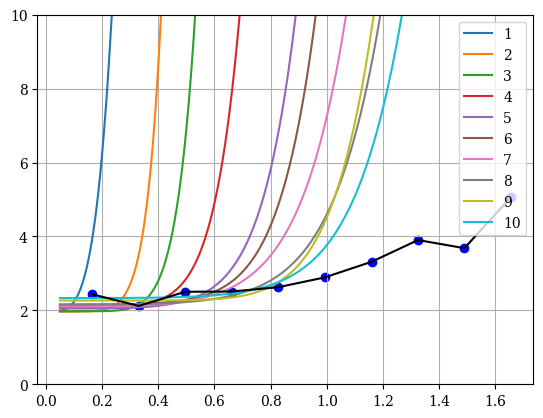

In [68]:
num_tuple=0
for (a0, b0, c0) in arr_abc:
    num_tuple+=1
    plt.plot(np.linspace(0.05, 1.5, 500), [1/effecive_mass_model(a, a0, b0, c0) for a in np.linspace(0.05, 1.5, 500)], label=num_tuple)
    plt.ylim(0, 10)
    

plt.grid()
plt.legend()
plt.plot(alphas[1:], 1/np.array(fit_alphas), color = 'black')
plt.scatter(alphas[1:], 1/np.array(fit_alphas), color = 'b')

## general $m^*$ dependence adjustment free tau

## real draft

In [ ]:
# # данные
# k_data = np.array(alphas[1:])
# y_data = 1 / np.array(fit_alphas)/2.15


# # модель с constraint:
# # a = b^2 / (6 c)
# def model(k, b, c):
#     a = b**2 / (6*c)
#     return a*k**4 + b*k**2 + c


# # начальные значения (из свободного polyfit)
# u = k_data**2
# a0, b0, c0 = np.polyfit(u, y_data, 2)

# p0 = [b0, c0]


# # фит
# params, cov = curve_fit(model, k_data, y_data, p0=p0)

# b, c = params
# a = b**2 / (6*c)


# print("Constrained fit coefficients:")
# print("a =", a)
# print("b =", b)
# print("c =", c)
# print("Check: b^2 / (6 a c) =", b**2/(6*a*c))


# # кривая
# k_fit = np.linspace(k_data.min(), k_data.max(), 400)
# y_fit = model(k_fit, b, c)


# # график
# plt.figure()
# plt.plot(k_data, y_data, 'o', label='data', color='b')
# plt.plot(k_fit, y_fit, '-', label=r"$a k^4 + b k^2 + c$", color='r')
# plt.xlabel(r'$\Delta k \,[\pi/a]$')
# plt.ylabel(r'$m^*\;[\mathrm{a.u.}]$')
# plt.legend()
# plt.grid(True)
# plt.show()